## Dependances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import moviepy
import moviepy.editor as mp
import time
from IPython.display import clear_output
from tqdm import tqdm
from ultralytics import YOLO
import torch
import av
import numpy as np
import pandas as pd
from PIL import Image
import moviepy
import moviepy.editor as mp
from IPython.display import clear_output
import tempfile
import seaborn as sns
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2

# from IPython.display import Video

In [2]:
# Define a function to determine the state based on conditions
def determine_state(row):
    if row['Healthy']:
        return 'Healthy'
    elif row['Diarrhé'] and row['Pneumonie']:
        return 'Diarrhé_Pneumonie'
    elif row['Diarrhé']:
        return 'Diarrhé'
    elif row['Pneumonie']:
        return 'Pneumonie'
    else:
        return 'Unknown'

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"


# Function to sample uniformly
def uniform_sample(df, sample_size, groupby_cols):
    # Calculate the number of rows to sample per group
    num_groups = df.groupby(groupby_cols).ngroups
    sample_per_group = max(sample_size // num_groups, 1)
    
    # Sample uniformly within each group
    sampled_df = df.groupby(groupby_cols, group_keys=False).apply(lambda x: x.sample(min(len(x), sample_per_group)))
    
    # If we sampled less than the desired sample_size due to group sizes, sample more from the remaining dataframe
    # if len(sampled_df) < sample_size:
    #     remaining_sample_size = sample_size - len(sampled_df)
    #     remaining_df = df[~df.index.isin(sampled_df.index)]
    #     additional_samples = remaining_df.sample(min(len(remaining_df), remaining_sample_size))
    #     sampled_df = pd.concat([sampled_df, additional_samples])
    
    return sampled_df

# Function to sample uniformly with specified values
def uniform_sample_with_values(df, sample_size, groupby_cols, filter_values = None):
    copy = df.copy(deep=True)
    # Filter dataframe based on specified values for each column
    if filter_values is not None:
        for col, values in filter_values.items():
            copy = copy[copy[col].isin(values)]
    
    # Calculate the number of rows to sample per group
    num_groups = copy.groupby(groupby_cols).ngroups
    sample_per_group = max(sample_size // num_groups, 1)
    
    # Sample uniformly within each group
    sampled_df = copy.groupby(groupby_cols, group_keys=False).apply(lambda x: x.sample(min(len(x), sample_per_group)))
    
    # If we sampled less than the desired sample_size due to group sizes, sample more from the remaining dataframe
    if len(sampled_df) < sample_size:
        remaining_sample_size = sample_size - len(sampled_df)
        remaining_df = copy[~copy.index.isin(sampled_df.index)]
        additional_samples = remaining_df.sample(min(len(remaining_df), remaining_sample_size))
        sampled_df = pd.concat([sampled_df, additional_samples])
    
    return sampled_df, copy[~copy.index.isin(sampled_df.index)]

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    # start_idx = end_idx - converted_len
    # start_idx = clip_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
        
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):

    bboxes = results['boxes']
    labels = results['labels']
    scores = results['scores']

    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))


def plot_gallery(image_paths, n_cols=5):
    n_images = len(image_paths)
    n_rows = n_images // n_cols + int(n_images % n_cols > 0)
    
    plt.figure(figsize=(20, n_rows * 4))
    print(n_rows, n_cols)
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()   

def plot_bbox_gallery(image_df, n_cols=5):
    n_images = image_df.shape[0]
    n_rows = n_images // n_cols + int(n_images % n_cols > 0)
    
    plt.figure(figsize=(20, n_rows * 4))
    for i, row in image_df.iterrows():
        img = Image.open(row["path"])
        # plt.subplot(n_rows, n_cols, i + 1)
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        # ax = plt.gca()
        score = row["conf"]
        box_x = row["box_x"]
        box_y = row["box_y"]
        box_width = row["box_width"]
        box_height = row["box_height"]
        box_x = box_x - (box_width / 2)
        box_y = box_y - (box_height / 2)
        rect = plt.Rectangle((box_x, box_y), box_width, box_height, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(box_x, box_y - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()   

In [21]:
def extract_medias(aptms, mp4_files, root_dir, frame_sample_rate = 4, num_images = 16, bbox_conf = (.8, .5), delta = 20, step = 0, video_model = None,  image_model = None):
    
    size = len(aptms)
    video_records = []
    image_records = []
    indices_records = []
    for idx in tqdm(range(size), desc="Processing items"):
        one_row = aptms.iloc[idx]
        target = one_row['State']
            
        cond = (
            (mp4_files["start_date"] == one_row.datetime.date())
            # (mp4_files["start_date"] == str(one_row.datetime.date()))
            & (mp4_files["start_time"] <= one_row.datetime)
            & (mp4_files["end_time"] > one_row.datetime)
            & (mp4_files["station"] == one_row.parc)
        )

        if mp4_files[cond].shape[0] == 0:
            continue

        video_dir_path = root_dir + "/videos/" + target
        if not os.path.exists(video_dir_path):
            os.makedirs(video_dir_path)

        image_dir_path = root_dir + "/images/" + target
        if not os.path.exists(image_dir_path):
            os.makedirs(image_dir_path)

        for index, file in mp4_files[cond].iterrows():
            zero = (one_row["datetime"] - file["start_time"]).total_seconds()
            if zero - delta > 0:
                break
    
        video = mp.VideoFileClip(file["path"])
        start_at = max(zero - delta, 0)
        end_at = max(zero - step, 0)
        
        # if end_at <= start_at or (end_at - start_at) <= 1:
        if end_at <= start_at or (end_at - start_at) < delta - step:
            continue

        # print(zero, start_at, end_at, file)
            
        clip = video.subclip(start_at, end_at)
        nfaces = 0
        
        with tempfile.NamedTemporaryFile(suffix='.mp4') as tmpfile:
            clip.write_videofile(tmpfile.name, logger= None)
            container = av.open(tmpfile.name)

            video_stream = container.streams.video[0]

            # Get the duration in time base units
            duration_in_units = video_stream.duration
            
            # Get the time base
            time_base = video_stream.time_base
            
            # Calculate the duration in seconds
            duration_in_seconds = duration_in_units * time_base

            # Sample 16 frames
            fps = int(container.streams.video[0].average_rate)
            seg_len = int(duration_in_seconds) * fps
            sample_rate = min(int(seg_len // num_images), frame_sample_rate)
            indices = sample_frame_indices(clip_len=num_images, frame_sample_rate=sample_rate, seg_len=seg_len)
            video_frames = read_video_pyav(container, indices)
            # image_frames = [Image.fromarray(frame) for frame in video_frames]
            video_images = [Image.fromarray(frame) for frame in video_frames]
            results = video_model.predict(video_images, save=False, imgsz=640, conf=bbox_conf[1], max_det=1, show=False)

            frames_idx = []
            image_frames = []
            for i, r in enumerate(results):
                if r.boxes.shape[0] != 0:
                    nfaces += 1
                    frames_idx.append(indices[i])
                    image_frames.append(video_images[i])
                    
                # else:
                    # nfaces = 0
                    
        if nfaces < 1:
        # if nfaces < 5:
            continue

        results = image_model.predict(image_frames, save=False, imgsz=640, conf=bbox_conf[0], max_det=1, show=False)
        result_records = []
        image_indices = []
        for frame_id, r in enumerate(results):
            if r.boxes.shape[0] == 0:
                continue
                # conf = 0
                # x1, y1, width, height = 0, 0, 0, 0
            else:
                conf = r.boxes.cpu().numpy().conf[0]
                x1, y1, width, height =  r.boxes.cpu().numpy().xywh[0]

            img = image_frames[frame_id]
            filename = f"image_{frames_idx[frame_id]}_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            # filename = f"image_{indices[frame_id]}_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            # filename = f"image_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            img_save_path = os.path.join(image_dir_path, filename)
            img.save(img_save_path)
            image_indices.append(frames_idx[frame_id])
            # image_indices.append(indices[frame_id])

            result_records.append({
                "image": filename,
                "path": img_save_path,
                "label": target,
                "calf": one_row["calfNumber"],
                "station": one_row["parc"],
                "before": one_row["datetime"],
                "from": file["path"],
                "conf": conf, 
                "box_x": x1,
                "box_y": y1,
                "box_width": width,
                "box_height": height,
                # "passed": r.boxes.shape[0] == 0
            })

        # if len(result_records) == 0:
        # if len(result_records) <= 1:
        #     continue

        # else:
        #     image_records.extend(result_records)
        image_records.extend(result_records)
        # nfaces = len(result_records)

        filename = f"clip_{idx}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.mp4"
        # temp_path = f"{video_dir_path}/{filename}"
        temp_path = f"{video_dir_path}/{nfaces}_{filename}"
        clip.write_videofile(temp_path, logger= None)
        
        indices_records.extend([{"fps": fps, "seg_len": seg_len, "sample_rate": sample_rate, "idx": idx, "from": temp_path} for idx in image_indices])
        
        video_records.append({
            "video": filename,
            "path": temp_path,
            "label": target,
            "duration": end_at - start_at,
            "calf": one_row["calfNumber"],
            "station": one_row["parc"],
            "before": one_row["datetime"],
            "from": file["path"],
            "ncalfs": nfaces,
            "nfaces": len(result_records),
        })
    
    clear_output()
    return pd.DataFrame(video_records), pd.DataFrame(image_records), pd.DataFrame(indices_records)

In [27]:
def extract_medias(aptms, mp4_files, root_dir, frame_sample_rate = 4, num_images = 16, bbox_conf = (.8, .5), delta = 20, step = 0, video_model = None,  image_model = None):
    
    size = len(aptms)
    video_records = []
    image_records = []
    indices_records = []
    for idx in tqdm(range(size), desc="Processing items"):
        one_row = aptms.iloc[idx]
        target = one_row['State']
            
        cond = (
            (mp4_files["start_date"] == one_row.datetime.date())
            # (mp4_files["start_date"] == str(one_row.datetime.date()))
            & (mp4_files["start_time"] <= one_row.datetime)
            & (mp4_files["end_time"] > one_row.datetime)
            & (mp4_files["station"] == one_row.parc)
        )

        if mp4_files[cond].shape[0] == 0:
            continue

        video_dir_path = root_dir + "/videos/" + target
        if not os.path.exists(video_dir_path):
            os.makedirs(video_dir_path)

        image_dir_path = root_dir + "/images/" + target
        if not os.path.exists(image_dir_path):
            os.makedirs(image_dir_path)

        for index, file in mp4_files[cond].iterrows():
            zero = (one_row["datetime"] - file["start_time"]).total_seconds()
            if zero - delta > 0:
                break
    
        video = mp.VideoFileClip(file["path"])
        start_at = max(zero - delta, 0)
        end_at = max(zero - step, 0)
        
        # if end_at <= start_at or (end_at - start_at) <= 1:
        if end_at <= start_at or (end_at - start_at) < delta - step:
            continue

        # print(zero, start_at, end_at, file)
            
        clip = video.subclip(start_at, end_at)
        nfaces = 0
        
        with tempfile.NamedTemporaryFile(suffix='.mp4') as tmpfile:
            clip.write_videofile(tmpfile.name, logger= None)
            container = av.open(tmpfile.name)

            video_stream = container.streams.video[0]

            # Get the duration in time base units
            duration_in_units = video_stream.duration
            
            # Get the time base
            time_base = video_stream.time_base
            
            # Calculate the duration in seconds
            duration_in_seconds = duration_in_units * time_base

            # Sample 16 frames
            fps = int(container.streams.video[0].average_rate)
            seg_len = int(duration_in_seconds) * fps
            sample_rate = min(int(seg_len // num_images), frame_sample_rate)
            indices = sample_frame_indices(clip_len=num_images, frame_sample_rate=sample_rate, seg_len=seg_len)
            video_frames = read_video_pyav(container, indices)
            image_frames = [Image.fromarray(frame) for frame in video_frames]
            # video_images = [Image.fromarray(frame) for frame in video_frames]
            # results = video_model.predict(video_images, save=False, imgsz=640, conf=bbox_conf[1], max_det=1, show=False)

            # frames_idx = []
            # image_frames = []
            # for i, r in enumerate(results):
            #     if r.boxes.shape[0] != 0:
            #         nfaces += 1
            #         frames_idx.append(indices[i])
            #         image_frames.append(video_images[i])
                    
                # else:
                    # nfaces = 0
                    
        # if nfaces <= 1:
        # # if nfaces < 5:
        #     continue

        results = image_model.predict(image_frames, save=False, imgsz=640, conf=bbox_conf[0], max_det=1, show=False)
        result_records = []
        image_indices = []
        for frame_id, r in enumerate(results):
            if r.boxes.shape[0] == 0:
                continue
                # conf = 0
                # x1, y1, width, height = 0, 0, 0, 0
            else:
                conf = r.boxes.cpu().numpy().conf[0]
                x1, y1, width, height =  r.boxes.cpu().numpy().xywh[0]

            img = image_frames[frame_id]
            # filename = f"image_{frames_idx[frame_id]}_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            filename = f"image_{indices[frame_id]}_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            # filename = f"image_{idx}_{frame_id}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.png"
            img_save_path = os.path.join(image_dir_path, filename)
            img.save(img_save_path)
            # image_indices.append(frames_idx[frame_id])
            image_indices.append(indices[frame_id])

            result_records.append({
                "image": filename,
                "path": img_save_path,
                "label": target,
                "calf": one_row["calfNumber"],
                "station": one_row["parc"],
                "before": one_row["datetime"],
                "from": file["path"],
                "conf": conf, 
                "box_x": x1,
                "box_y": y1,
                "box_width": width,
                "box_height": height,
                # "passed": r.boxes.shape[0] == 0
            })

        # if len(result_records) == 0:
        # if len(result_records) < 1:
        #     continue
            
            
        image_records.extend(result_records)
        nfaces = len(result_records)

        filename = f"clip_{idx}_{one_row['calfNumber']}_{one_row['parc']}_{one_row['datetime']}_{target}.mp4"
        # temp_path = f"{video_dir_path}/{filename}"
        temp_path = f"{video_dir_path}/{nfaces}_{filename}"
        clip.write_videofile(temp_path, logger= None)
        
        indices_records.extend([{"fps": fps, "seg_len": seg_len, "sample_rate": sample_rate, "idx": idx, "from": temp_path} for idx in image_indices])
        
        video_records.append({
            "video": filename,
            "path": temp_path,
            "label": target,
            "duration": end_at - start_at,
            "calf": one_row["calfNumber"],
            "station": one_row["parc"],
            "before": one_row["datetime"],
            "from": file["path"],
            "nfaces": nfaces
        })
    
    clear_output()
    return pd.DataFrame(video_records), pd.DataFrame(image_records), pd.DataFrame(indices_records)

## About the data

In [3]:
# Read the CSV file into a DataFrame
states = pd.read_csv('/data/konrad/video_classification/illness.csv')
aptm = pd.read_csv('/data/konrad/video_classification/visits_point.csv', delimiter=';')

# Display the DataFrame
states.head()

Healthy  Diarrhé  Pneumonie  No ATQ  somme_valeur_signes  somme_signe  \
0    False    False      False    6768                    3            1   
1    False     True      False    6780                    3            1   
2    False     True      False    6778                    3            1   
3    False     True      False    6391                    3            1   
4    False    False      False    6783                    2            1   

   Score_Temperature  Tête  Yeux  Toux  Naseaux  Fèces        date  
0                  0     2     1     0        1      1  2022-02-14  
1                  0     2     0     0        1      3  2022-02-14  
2                  0     3     1     0        0      3  2022-02-14  
3                  0     0     2     1        0      3  2022-02-14  
4                  0     2     0     0        0      1  2022-02-14

In [183]:
aptm.head()

calfNumber  feedingDay  feeder    feederLong              initial group  \
0        6685          30    2494  DAL 1 (2494)  2021-12-09T16:19:24     A   
1        6321          35    2494  DAL 1 (2494)  2021-12-04T14:29:18     A   
2        6321          35    2494  DAL 1 (2494)  2021-12-04T14:29:18     A   
3        6675          35    2494  DAL 1 (2494)  2021-12-04T14:50:45     A   
4        6675          35    2494  DAL 1 (2494)  2021-12-04T14:50:45     A   

   station  Station                 date  Activity  ...            localDate  \
0      1.0        0  2022-01-07T23:59:38         0  ...  2022-01-07T18:59:34   
1      1.0        0  2022-01-07T23:59:07         0  ...  2022-01-07T18:59:03   
2      1.0        0  2022-01-07T23:58:45         0  ...  2022-01-07T18:58:41   
3      1.0        0  2022-01-07T23:58:16         0  ...  2022-01-07T18:58:13   
4      1.0        0  2022-01-07T23:57:40         0  ...  2022-01-07T18:57:37   

   ScaleValid  ScaleValidFlag  Type  Weight  \
0       False               0  wEnt       0   
1       False               0  wEnt       0   
2       False               0  wEnt       0   
3       False               0  wEnt       0   
4       False               0  wEnt       0   

                                                 _id  \
0  calfHistory:2494-cdadd262-8004-4048-8481-82843...   
1  calfHistory:2494-478d13a3-ad67-4138-b051-e8b00...   
2  calfHistory:2494-478d13a3-ad67-4138-b051-e8b00...   
3  calfHistory:2494-a4533776-97e0-41e1-83ed-caaf3...   
4  calfHistory:2494-a4533776-97e0-41e1-83ed-caaf3...   

                                        calf            datetime         day  \
0  2494-cdadd262-8004-4048-8481-828438ed6a2b 2022-01-07 18:59:34  2022-01-07   
1  2494-478d13a3-ad67-4138-b051-e8b00841caff 2022-01-07 18:59:03  2022-01-07   
2  2494-478d13a3-ad67-4138-b051-e8b00841caff 2022-01-07 18:58:41  2022-01-07   
3  2494-a4533776-97e0-41e1-83ed-caaf3b639bb8 2022-01-07 18:58:13  2022-01-07   
4  2494-a4533776-97e0-41e1-83ed-caaf3b639bb8 2022-01-07 18:57:37  2022-01-07   

       hour  
0  18:59:34  
1  18:59:03  
2  18:58:41  
3  18:58:13  
4  18:57:37  

[5 rows x 30 columns]

In [36]:
states.shape

(1829, 13)

In [7]:
states.date.unique()

array(['2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
       '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21',
       '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
       '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01',
       '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05',
       '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09',
       '2022-03-10', '2022-03-11', '2022-03-12', '2022-03-13',
       '2022-03-15', '2022-03-16', '2022-03-18', '2022-03-21',
       '2022-03-23', '2022-03-25', '2022-03-28', '2022-03-30',
       '2022-04-01', '2022-04-04', '2022-04-06', '2022-04-08',
       '2022-04-15'], dtype=object)

In [15]:
states.date.unique().size

41

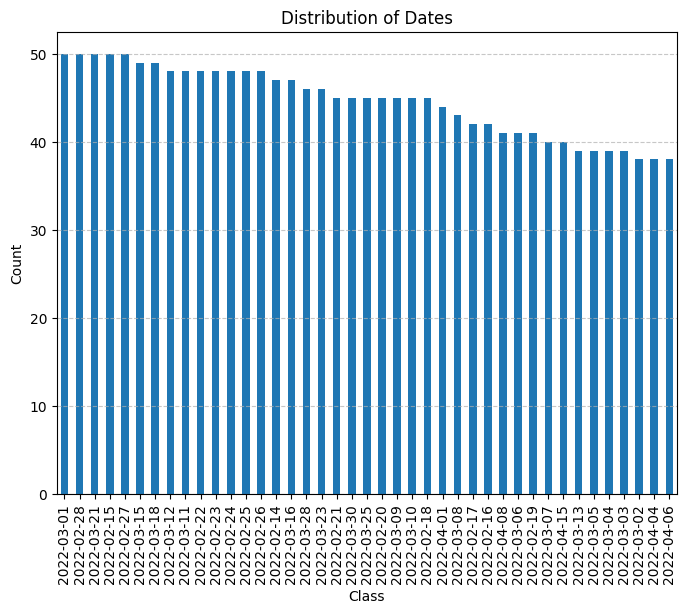

In [10]:
# Count the occurrences of each class
counts = states['date'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.title('Distribution of Dates')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
states['date'].value_counts().mean()

44.609756097560975

Supposans que chaque veau evaluer pendant les 41 jours fait au moins une visite au louve, on peut esperer le nombre suivant de videos au minimum apres extraction: 

In [16]:
states['date'].value_counts().mean() * states.date.unique().size

1829.0

In [32]:
# Healthy Diarrhé Pneumonievalue_counts
states[(states["Diarrhé"] == True) & (states["Pneumonie"] == True)].shape

(142, 13)

In [34]:
states[(states["Diarrhé"] == True) & (states["Pneumonie"] == True)]["date"].unique().size

38

In [35]:
states[(states["Diarrhé"] == True) & (states["Pneumonie"] == True)]["date"].value_counts()

date
2022-03-02    8
2022-03-04    8
2022-02-22    7
2022-02-16    6
2022-02-17    6
2022-02-24    6
2022-02-25    6
2022-03-05    5
2022-02-18    5
2022-04-01    5
2022-03-10    5
2022-03-07    5
2022-02-26    5
2022-03-23    4
2022-02-15    4
2022-03-03    4
2022-02-14    4
2022-02-23    4
2022-02-28    4
2022-04-08    3
2022-03-16    3
2022-04-06    3
2022-02-19    3
2022-03-30    3
2022-03-28    3
2022-02-21    3
2022-03-25    2
2022-02-20    2
2022-03-21    2
2022-03-01    2
2022-03-12    2
2022-03-09    2
2022-03-06    2
2022-03-13    2
2022-03-15    1
2022-03-11    1
2022-03-08    1
2022-02-27    1
Name: count, dtype: int64

There are some row where the calf has two illness at the same time. 

- We can use them as it, but here we are training a model to distinguished one illness at a time
- We can train with and without
- We can train on a multi-class task with the whole dataset or only the subset with two illness but, the target can be the orignal three class because, a calf can't be heatly and has Pneumonia at the same time. Need to adapt to that. Can use a multi-modality in this case, or a soft-label to allow the model to predict a percentage of a state. 

In [37]:
states[["Healthy",	"Diarrhé", 	"Pneumonie", 	"No ATQ"]]

Healthy  Diarrhé  Pneumonie  No ATQ
0       False    False      False    6768
1       False     True      False    6780
2       False     True      False    6778
3       False     True      False    6391
4       False    False      False    6783
...       ...      ...        ...     ...
1824     True    False      False    6799
1825     True    False      False    6821
1826     True    False      False    6405
1827     True    False      False    6404
1828     True    False      False    6412

[1829 rows x 4 columns]

In [80]:
states[states["State"].isna()]

Healthy  Diarrhé  Pneumonie  No ATQ  somme_valeur_signes  somme_signe  \
0       False    False      False    6768                    3            1   
4       False    False      False    6783                    2            1   
26      False    False      False    6707                    4            1   
27      False    False      False    6712                    4            2   
28      False    False      False    6337                    4            1   
...       ...      ...        ...     ...                  ...          ...   
1782    False    False      False    6799                    3            1   
1785    False    False      False    6823                    4            1   
1786    False    False      False    6405                    3            1   
1787    False    False      False    6410                    3            1   
1788    False    False      False    6821                    4            1   

      Score_Temperature  Tête  Yeux  Toux  Naseaux  Fèces        date State  
0                     0     2     1     0        1      1  2022-02-14  None  
4                     0     2     0     0        0      1  2022-02-14  None  
26                    0     3     1     0        1      0  2022-02-14  None  
27                    0     2     1     2        0      1  2022-02-14  None  
28                    0     3     1     0        1      1  2022-02-14  None  
...                 ...   ...   ...   ...      ...    ...         ...   ...  
1782                  0     0     1     2        0      0  2022-04-08  None  
1785                  0     0     1     1        2      0  2022-04-08  None  
1786                  0     2     0     0        1      0  2022-04-08  None  
1787                  0     0     0     3        0      0  2022-04-08  None  
1788                  0     0     0     3        1      0  2022-04-08  None  

[594 rows x 14 columns]

We will work without undefined state about calf    

## Extraction test

In [4]:
DATA_DIR = "/data/public/heureux_2022-02-16_2022-04-16"
# Specify the directory path
dir_path = DATA_DIR

# List all directories in the specified directory
directories = [d for d in os.listdir(dir_path) if d.startswith("2022") and os.path.isdir(os.path.join(dir_path, d))]

# Print the list of directories
# print(directories)

In [5]:
day_to_dir = {}
for d in directories:
    if d.startswith("2022-"):
        p = d.split("-")
        start_date = "-".join(p[:3])
        end_date = "-".join(p[3:])
        date_range = pd.date_range(start=start_date, end=end_date)
        day_to_dir.update({md:d for md in date_range.strftime('%Y-%m-%d').tolist()})

day_to_dir['2022-02-02'] = "2022_02_02"
# day_to_dir

In [6]:
states['State'] = states.apply(determine_state, axis=1)
states = states[~states["State"].isna()]

In [82]:
states[(states["Diarrhé"] == True) & (states["Pneumonie"] == True)][['State', 'No ATQ', 'date']].head()

State  No ATQ        date
8   Diarrhé, Pneumonie    6385  2022-02-14
14  Diarrhé, Pneumonie    6382  2022-02-14
15  Diarrhé, Pneumonie    6760  2022-02-14
19  Diarrhé, Pneumonie    6370  2022-02-14
69  Diarrhé, Pneumonie    6780  2022-02-15

In [7]:
columns = ["calfNumber", "station", "Duration", "localDate", "date", "feederLong"]
aptm["datetime"] = pd.to_datetime(aptm["localDate"])
aptm["day"] = aptm["datetime"].dt.date
aptm["hour"] = aptm["datetime"].dt.time
# Only data for eval date
stated_aptm = aptm[aptm["day"].apply(str).isin(states.date.unique())][columns + ["day", "hour", "datetime"]]
stated_aptm["parc"] = None
stated_aptm.loc[(stated_aptm["station"]==1) & (stated_aptm["feederLong"]=="DAL 2 (2496)"), 'parc']="9" #louve 3
stated_aptm.loc[(stated_aptm["station"]==2) & (stated_aptm["feederLong"]=="DAL 2 (2496)"), 'parc']="10" #louve 4
stated_aptm.loc[(stated_aptm["station"]==2) & (stated_aptm["feederLong"]=="DAL 1 (2494)"), 'parc']="1"  #louve 2 
stated_aptm.loc[(stated_aptm["station"]==1) & (stated_aptm["feederLong"]=="DAL 1 (2494)"), 'parc']="2" #louve 1
stated_aptm = stated_aptm[stated_aptm["Duration"] > 0]
stated_aptm = stated_aptm[~stated_aptm["parc"].isna()]
# Only data for available recorded video dates
stated_aptm = stated_aptm[stated_aptm["day"].apply(str).isin(day_to_dir.keys())]
# Only apptm for available recorded video hour
stated_aptm = stated_aptm[(stated_aptm["datetime"].dt.hour >= 6) & (stated_aptm["datetime"].dt.hour <= 22)]
stated_aptm.head()

calfNumber  station  Duration            localDate  \
29135        6791      1.0       478  2022-02-18T18:59:51   
29136        6761      2.0       271  2022-02-18T18:57:44   
29137        6370      2.0        35  2022-02-18T18:57:09   
29138        6791      1.0       260  2022-02-18T18:54:29   
29140        6768      1.0       136  2022-02-18T18:52:10   

                      date    feederLong         day      hour  \
29135  2022-02-18T23:59:53  DAL 1 (2494)  2022-02-18  18:59:51   
29136  2022-02-18T23:57:46  DAL 2 (2496)  2022-02-18  18:57:44   
29137  2022-02-18T23:57:12  DAL 2 (2496)  2022-02-18  18:57:09   
29138  2022-02-18T23:54:31  DAL 1 (2494)  2022-02-18  18:54:29   
29140  2022-02-18T23:52:12  DAL 1 (2494)  2022-02-18  18:52:10   

                 datetime parc  
29135 2022-02-18 18:59:51    2  
29136 2022-02-18 18:57:44   10  
29137 2022-02-18 18:57:09   10  
29138 2022-02-18 18:54:29    2  
29140 2022-02-18 18:52:10    2

In [10]:
stated_aptm.shape, aptm.shape, (stated_aptm.shape[0] / aptm.shape[0]) * 100

((13497, 10), (192755, 30), 7.002152992140282)

In [8]:
# Specify the directory path
dir_path = DATA_DIR

# List all directories in the specified directory
directories = [d for d in os.listdir(dir_path) if d.startswith("2022") and os.path.isdir(os.path.join(dir_path, d))]

mp4_files = []
for d in directories:
    try:
        path = dir_path + "/" + d
        # print(path)
        for f in os.listdir(path):
            if f.endswith(".mp4") and os.path.isfile(os.path.join(path, f)):
                filename = f[:-4].split("_")
                start_date = filename[3][:4] + "-" + filename[3][4:6] + "-" + filename[3][6:8] + "T" + filename[3][8:10] + ":" + filename[3][10:12] + ":" + filename[3][12:]
                end_date = filename[4][:4] + "-" + filename[4][4:6] + "-" + filename[4][6:8] + "T" + filename[4][8:10] + ":" + filename[4][10:12] + ":" + filename[4][12:]
                station = filename[1][2:]
                # print(filename, start_date, end_date, station)
                # print(os.path.join(path, f))
                mp4_files.append({"station": station, "start_at": start_date, "end_at": end_date, "path": os.path.join(path, f)})
                # break
            
    except Exception as e:
        continue

mp4_files = pd.DataFrame(mp4_files)
mp4_files.head()

station             start_at               end_at  \
0       1  2022-03-04T20:00:00  2022-03-04T21:00:00   
1       1  2022-03-03T11:41:10  2022-03-03T13:00:00   
2       8  2022-02-28T09:00:07  2022-02-28T10:00:07   
3       4  2022-03-01T20:00:03  2022-03-01T21:00:03   
4       8  2022-03-04T08:00:07  2022-03-04T09:00:07   

                                                path  
0  /data/public/heureux_2022-02-16_2022-04-16/202...  
1  /data/public/heureux_2022-02-16_2022-04-16/202...  
2  /data/public/heureux_2022-02-16_2022-04-16/202...  
3  /data/public/heureux_2022-02-16_2022-04-16/202...  
4  /data/public/heureux_2022-02-16_2022-04-16/202...

In [9]:
mp4_files["start_time"] = pd.to_datetime(mp4_files["start_at"])
mp4_files["start_date"] = mp4_files["start_time"].dt.date
mp4_files["start_hour"] = mp4_files["start_time"].dt.hour
mp4_files["start_mn"] = mp4_files["start_time"].dt.minute
mp4_files = mp4_files[mp4_files["station"].isin(["1","2","9","10"])]
mp4_files.head()

station             start_at               end_at  \
0        1  2022-03-04T20:00:00  2022-03-04T21:00:00   
1        1  2022-03-03T11:41:10  2022-03-03T13:00:00   
5        2  2022-03-04T11:00:01  2022-03-04T12:00:01   
12       9  2022-03-01T13:00:08  2022-03-01T14:00:08   
13       9  2022-03-04T07:00:08  2022-03-04T08:00:08   

                                                 path          start_time  \
0   /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-04 20:00:00   
1   /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-03 11:41:10   
5   /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-04 11:00:01   
12  /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-01 13:00:08   
13  /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-04 07:00:08   

    start_date  start_hour  start_mn  
0   2022-03-04          20         0  
1   2022-03-03          11        41  
5   2022-03-04          11         0  
12  2022-03-01          13         0  
13  2022-03-04           7         0

In [13]:
mp4_files.shape

(3844, 8)

In [12]:
idx = 5
one_row = stated_aptm.iloc[idx]
one_row

calfNumber                   6746
station                       2.0
Duration                      338
localDate     2022-02-18T18:49:42
date          2022-02-18T23:49:44
feederLong           DAL 2 (2496)
day                    2022-02-18
hour                     18:49:42
datetime      2022-02-18 18:49:42
parc                           10
Name: 29142, dtype: object

In [104]:
row_state = states[(states["date"] == one_row["day"].strftime("%Y-%m-%d")) & (states["No ATQ"] == one_row["calfNumber"])]
row_state

Empty DataFrame
Columns: [Healthy, Diarrhé, Pneumonie, No ATQ, somme_valeur_signes, somme_signe, Score_Temperature, Tête, Yeux, Toux, Naseaux, Fèces, date, State]
Index: []

In [88]:
cond = (
    (mp4_files["start_date"] == one_row.datetime.date()) 
    & (mp4_files["start_hour"] == one_row.datetime.hour)
    & (mp4_files["start_mn"] <= one_row.datetime.minute)
    & (mp4_files["station"] == one_row.parc)
)
    
mp4_files[cond]

station             start_at               end_at  \
2441       2  2022-02-18T18:00:01  2022-02-18T19:00:01   

                                                   path          start_time  \
2441  /data/public/heureux_2022-02-16_2022-04-16/202... 2022-02-18 18:00:01   

      start_date  start_hour  start_mn  
2441  2022-02-18          18         0

In [89]:
file =  mp4_files[cond].iloc[0]
zero = (one_row["datetime"] - file["start_time"]).total_seconds()
video_name = file["path"]
zero, video_name

(1896.0,
 '/data/public/heureux_2022-02-16_2022-04-16/2022-02-16-2022-02-21/N862A6_ch2_main_20220218180001_20220218190001.mp4')

In [90]:
frame = 20
step = 0
delta = frame + step

In [91]:
video = mp.VideoFileClip(video_name)
clip = video.subclip(zero - delta, zero - step)
# Start time
start_time = time.time()

# Code to monitor
temp_path = f"temp_videos/temp_clip{idx}.mp4"
clip.write_videofile(temp_path)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

formatted_time = format_time(elapsed_time)

# Display the elapsed time
print(f"Time of execution: {formatted_time}")

Moviepy - Building video temp_videos/temp_clip7.mp4.
MoviePy - Writing audio in temp_clip7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip7.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip7.mp4
Time of execution: 00:00:05


In [105]:
# Start time
start_time = time.time()

for idx in range(10):
    one_row = stated_aptm.iloc[idx]
    row_state = states[(states["date"] == one_row["day"].strftime("%Y-%m-%d")) & (states["No ATQ"] == one_row["calfNumber"])]

    if row_state.shape[0] == 0:
        continue
    
    row_state = row_state.iloc[0]
    cond = (
        (mp4_files["start_date"] == one_row.datetime.date()) 
        & (mp4_files["start_hour"] == one_row.datetime.hour)
        & (mp4_files["start_mn"] <= one_row.datetime.minute)
        & (mp4_files["station"] == one_row.parc)
    )
        
    file =  mp4_files[cond].iloc[0]
    zero = (one_row["datetime"] - file["start_time"]).total_seconds()
    video_name = file["path"]

    video = mp.VideoFileClip(video_name)
    clip = video.subclip(zero - delta, zero - step)
    
    # Code to monitor
    temp_path = f"temp_videos/temp_clip{idx}.mp4"
    print(f"\n{temp_path} - {row_state['No ATQ']} - {row_state['State']}\n")
    clip.write_videofile(temp_path)


# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

formatted_time = format_time(elapsed_time)

# Display the elapsed time
print(f"Time of execution: {formatted_time} from {elapsed_time}")


temp_videos/temp_clip0.mp4 - 6791 - Diarrhé

Moviepy - Building video temp_videos/temp_clip0.mp4.
MoviePy - Writing audio in temp_clip0TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip0.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip0.mp4

temp_videos/temp_clip1.mp4 - 6761 - Pneumonie

Moviepy - Building video temp_videos/temp_clip1.mp4.
MoviePy - Writing audio in temp_clip1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip1.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip1.mp4

temp_videos/temp_clip2.mp4 - 6370 - Diarrhé, Pneumonie

Moviepy - Building video temp_videos/temp_clip2.mp4.
MoviePy - Writing audio in temp_clip2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip2.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip2.mp4

temp_videos/temp_clip3.mp4 - 6791 - Diarrhé

Moviepy - Building video temp_videos/temp_clip3.mp4.
MoviePy - Writing audio in temp_clip3TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip3.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip3.mp4

temp_videos/temp_clip4.mp4 - 6768 - Diarrhé

Moviepy - Building video temp_videos/temp_clip4.mp4.
MoviePy - Writing audio in temp_clip4TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip4.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip4.mp4

temp_videos/temp_clip6.mp4 - 6768 - Diarrhé

Moviepy - Building video temp_videos/temp_clip6.mp4.
MoviePy - Writing audio in temp_clip6TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip6.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip6.mp4

temp_videos/temp_clip7.mp4 - 6768 - Diarrhé

Moviepy - Building video temp_videos/temp_clip7.mp4.
MoviePy - Writing audio in temp_clip7TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip7.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip7.mp4

temp_videos/temp_clip8.mp4 - 6761 - Pneumonie

Moviepy - Building video temp_videos/temp_clip8.mp4.
MoviePy - Writing audio in temp_clip8TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip8.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip8.mp4

temp_videos/temp_clip9.mp4 - 6768 - Diarrhé

Moviepy - Building video temp_videos/temp_clip9.mp4.
MoviePy - Writing audio in temp_clip9TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video temp_videos/temp_clip9.mp4



Moviepy - Done !
Moviepy - video ready temp_videos/temp_clip9.mp4
Time of execution: 00:00:51 from 51.11439299583435


## Data selections

In [13]:
print(f"Nombre de visites de veaux dont on connait l'etat a la date {stated_aptm.shape[0]}")

print(f"Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) {format_time(5 *  stated_aptm.shape[0])}")

print(f"Nombre de temps pour l'extraction des visites de 20s (pour 51s/10 videos) {format_time(stated_aptm.shape[0] / 10 * 51)}")

print(f"Nombre d'heures extrait au total pour toutes les visites {format_time(stated_aptm.shape[0] * 20)}")

Nombre de visites de veaux dont on connait l'etat a la date 13497
Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) 18:44:45
Nombre de temps pour l'extraction des visites de 20s (pour 51s/10 videos) 19:07:14
Nombre d'heures extrait au total pour toutes les visites 74:59:00


In [14]:
nh = 2
h = 3600 * nh
nv = h // 20
print(f"Nombre de videos: {nv} videos pour {nh} heure")

print(f"Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) {format_time(5 * nv)}")

Nombre de videos: 360 videos pour 2 heure
Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) 00:30:00


In [161]:
stated_aptm["calfNumber"].unique().size

85

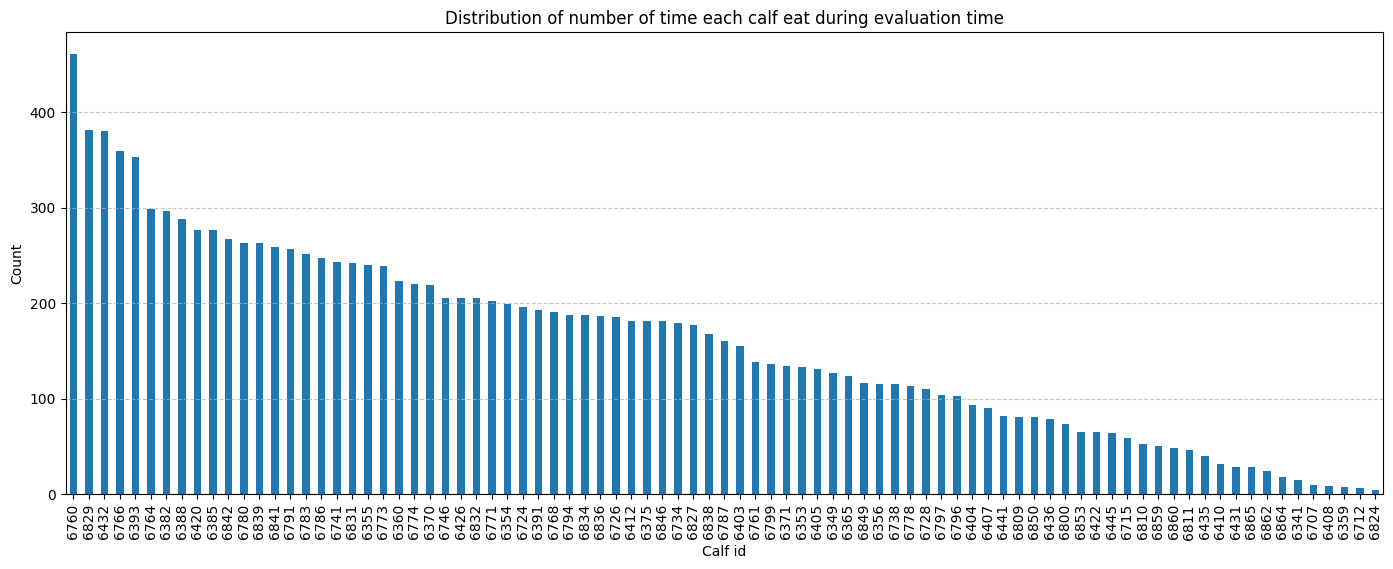

In [162]:
# Count the occurrences of each class
counts = stated_aptm['calfNumber'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Calf id')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [163]:
stated_aptm['calfNumber'].value_counts().describe()

count     85.000000
mean     158.788235
std      101.356055
min        4.000000
25%       79.000000
50%      161.000000
75%      223.000000
max      461.000000
Name: count, dtype: float64

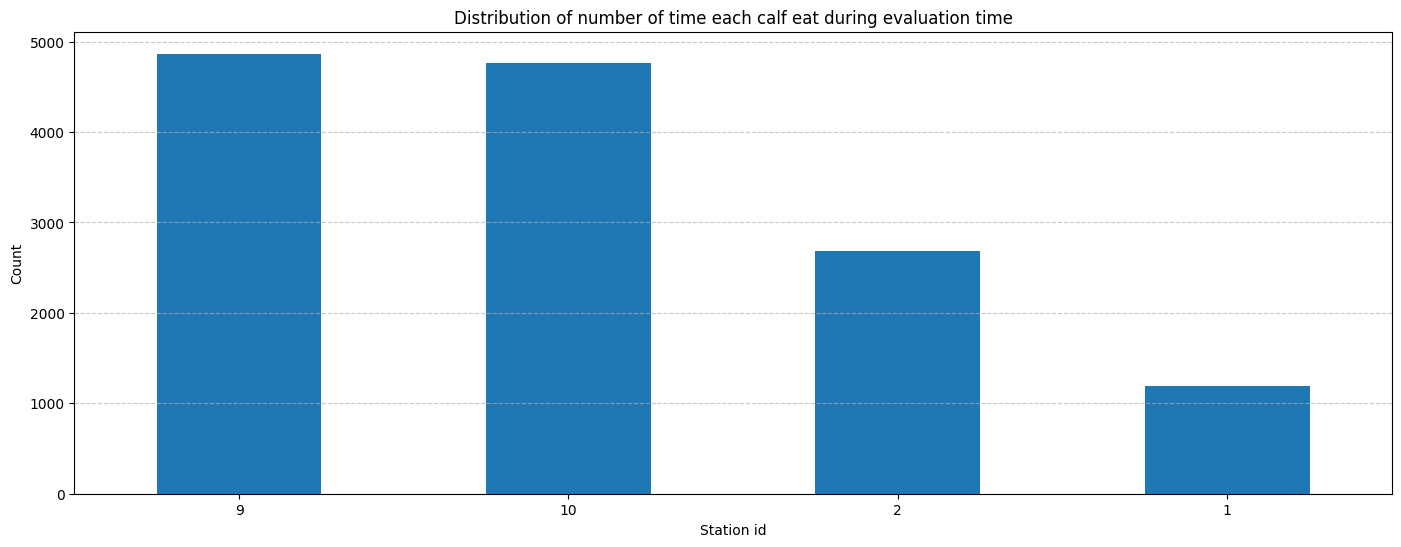

In [164]:
# Count the occurrences of each class
counts = stated_aptm['parc'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Station id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

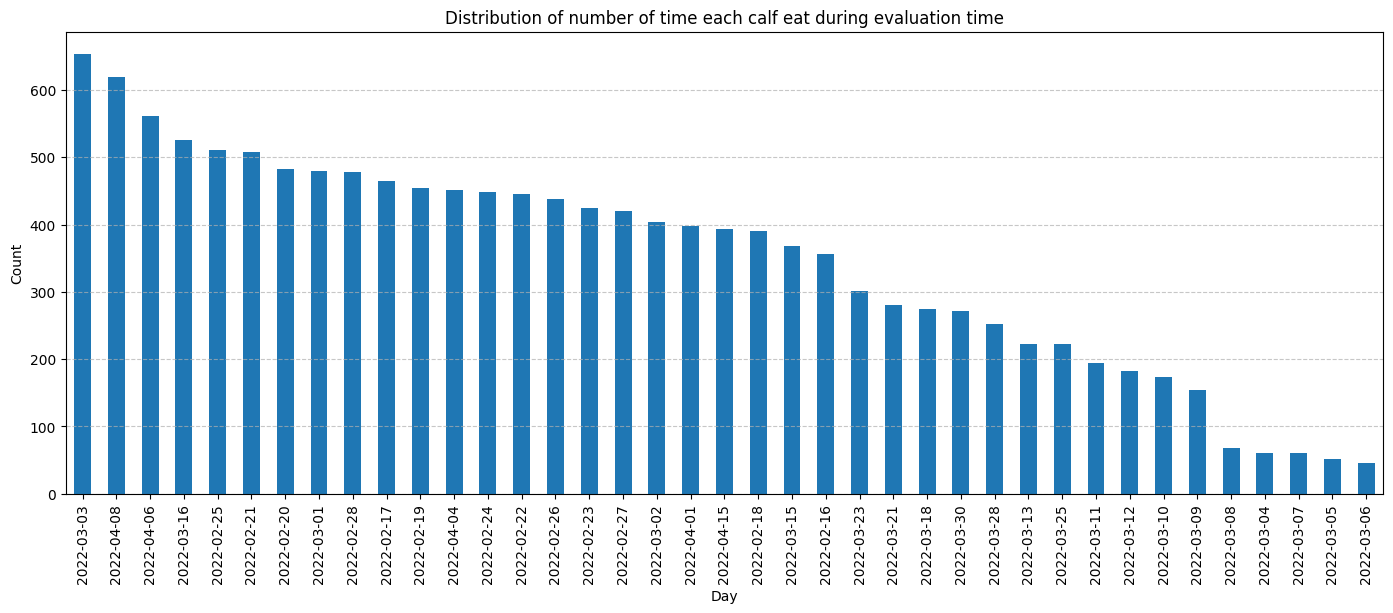

In [165]:
# Count the occurrences of each class
counts = stated_aptm['day'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
stated_aptm["cwd"] = stated_aptm["calfNumber"].astype(str) + " " + stated_aptm["day"].astype(str)
states["cwd"] = states["No ATQ"].astype(str) + " " + states["date"].astype(str)
aptm_with_state = pd.merge(stated_aptm[["calfNumber", "parc", "day", "Duration", "cwd", "datetime"]], states[["State", "cwd"]], on="cwd", how='inner')
aptm_with_state.head()

calfNumber parc         day  Duration              cwd            datetime  \
0        6791    2  2022-02-18       478  6791 2022-02-18 2022-02-18 18:59:51   
1        6791    2  2022-02-18       260  6791 2022-02-18 2022-02-18 18:54:29   
2        6791    2  2022-02-18       276  6791 2022-02-18 2022-02-18 16:24:18   
3        6791    2  2022-02-18       200  6791 2022-02-18 2022-02-18 16:17:38   
4        6791    2  2022-02-18        13  6791 2022-02-18 2022-02-18 16:07:37   

     State  
0  Diarrhé  
1  Diarrhé  
2  Diarrhé  
3  Diarrhé  
4  Diarrhé

In [16]:
aptm_with_state.shape, stated_aptm.shape, states.shape, 

((13296, 7), (13497, 11), (1829, 15))

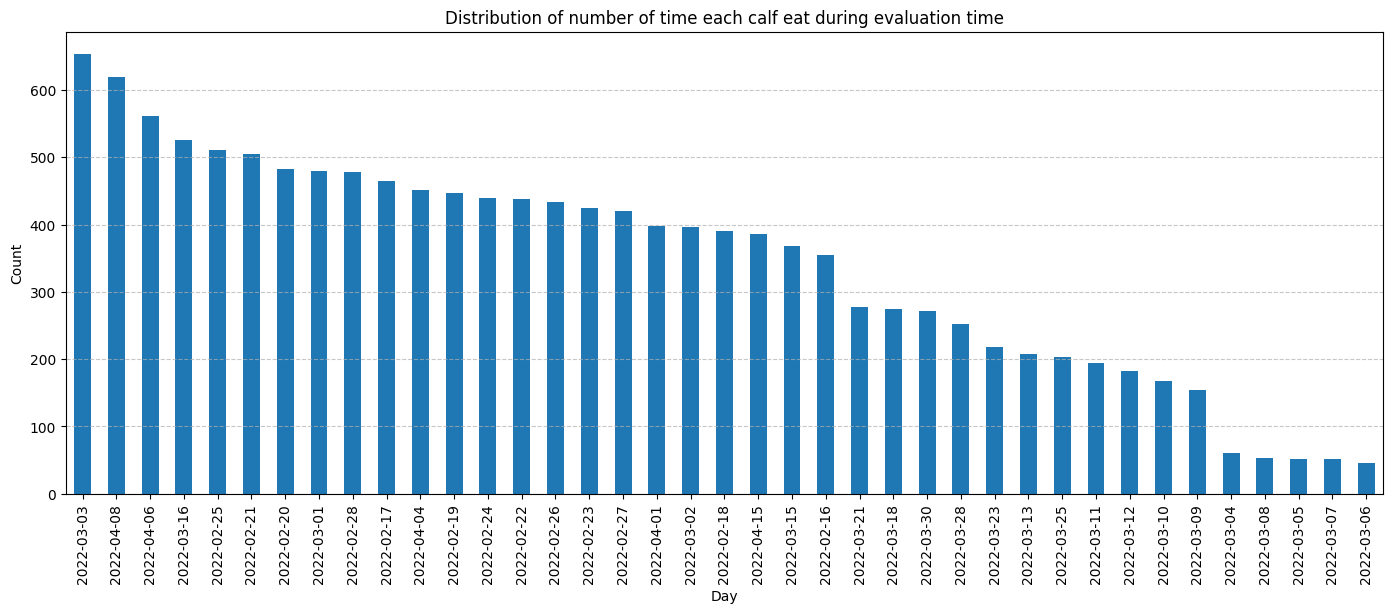

In [17]:
# Count the occurrences of each class
counts = aptm_with_state['day'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

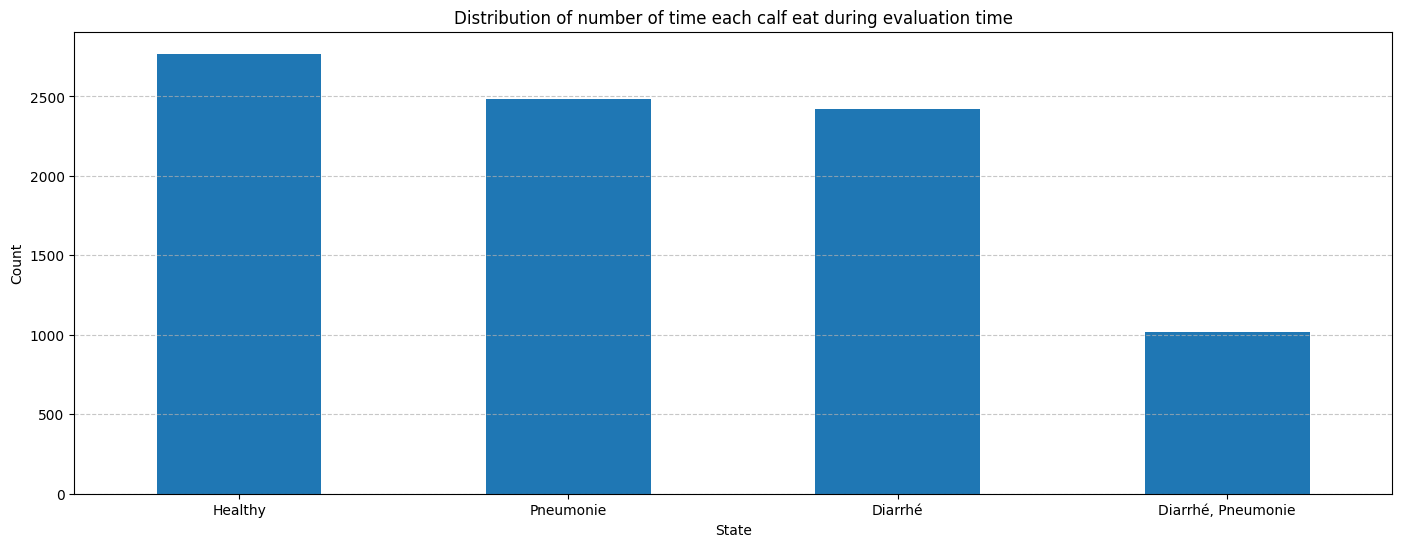

In [169]:
# Count the occurrences of each class
counts = aptm_with_state['State'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

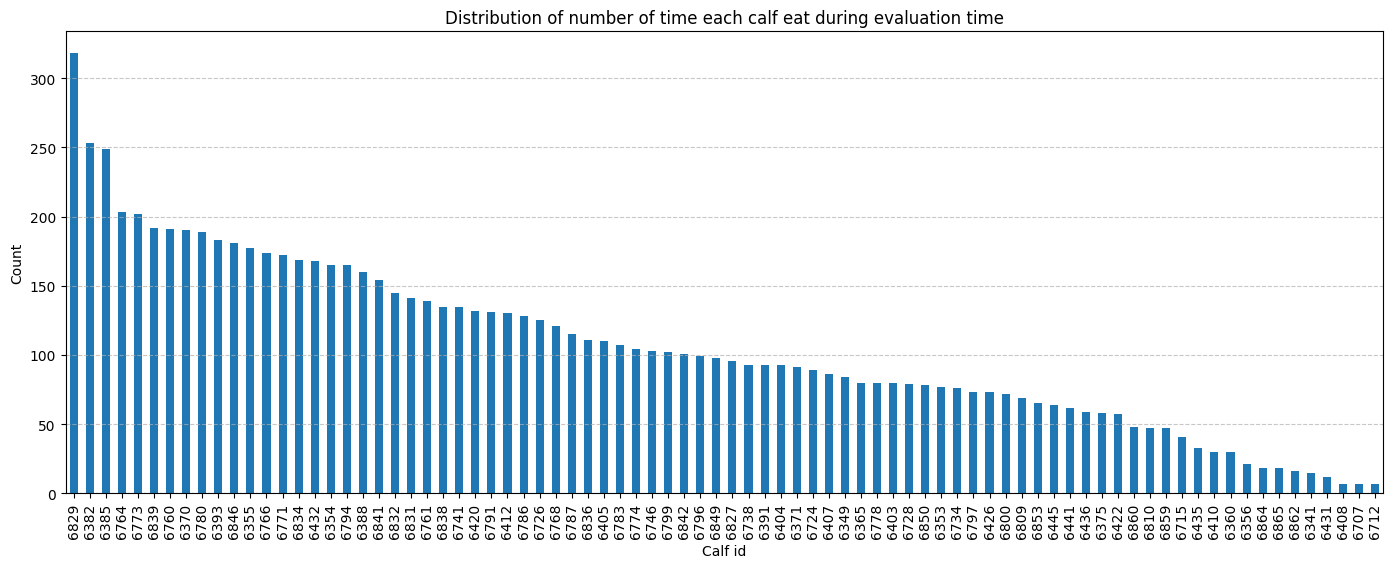

In [170]:
# Count the occurrences of each class
counts = aptm_with_state['calfNumber'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Calf id')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

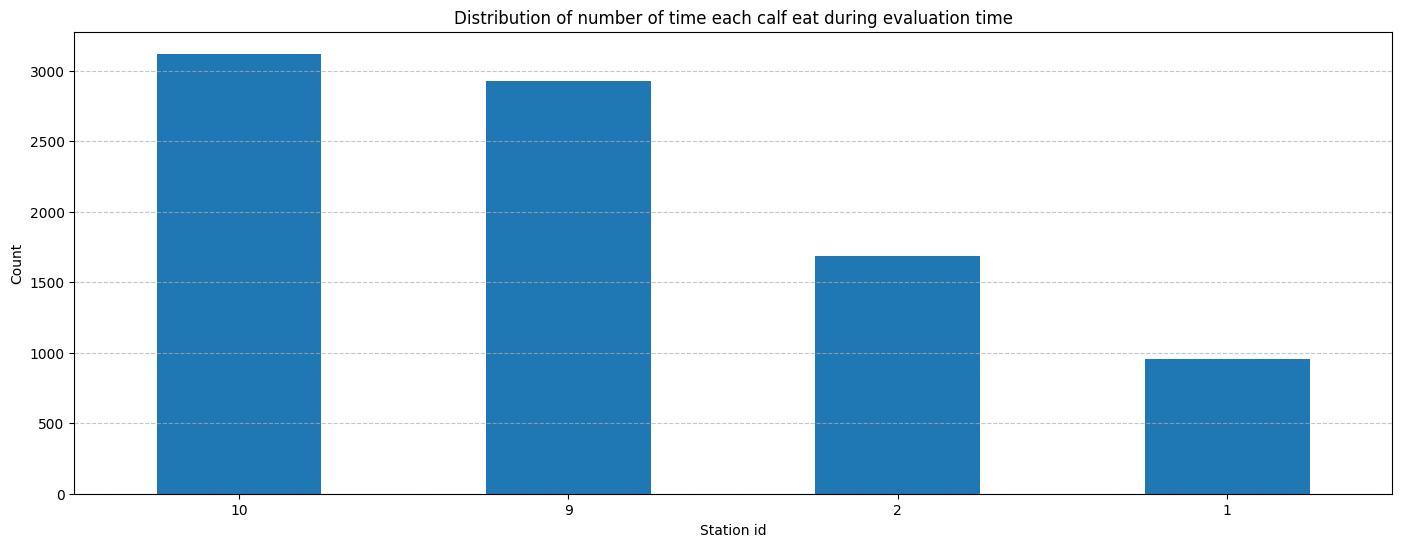

In [171]:
# Count the occurrences of each class
counts = aptm_with_state['parc'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Station id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:

# Specify the columns to group by and the sample size
groupby_cols = ['calfNumber', 'parc', 'State']
sample_size = 500

selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() > 150].keys()
filter_values = {
    'calfNumber': selected_calf,  # Specify the values you want to include
    'State': ['Diarrhé', 'Pneumonie', 'Healthy']
}

# Get the uniformly sampled dataframe
# sampled_df = uniform_sample(aptm_with_state, sample_size, groupby_cols)
aptm_sampled, aptm_rest = uniform_sample_with_values(aptm_with_state, sample_size, groupby_cols, filter_values = filter_values)

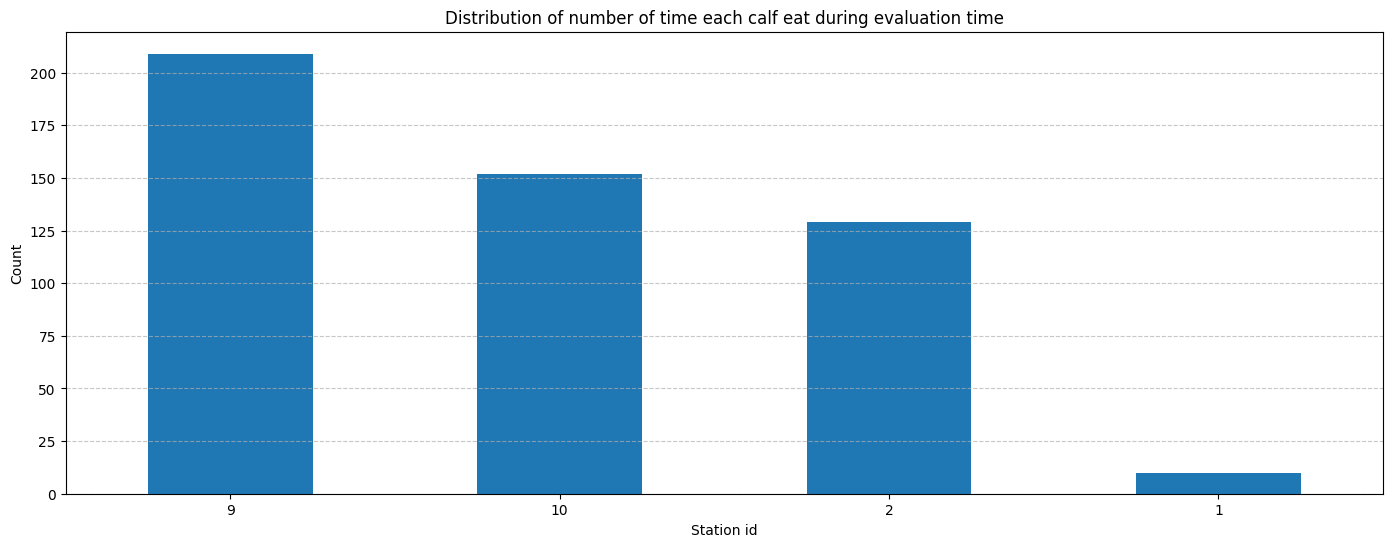

In [19]:
# Count the occurrences of each class
counts = aptm_sampled['parc'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Station id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

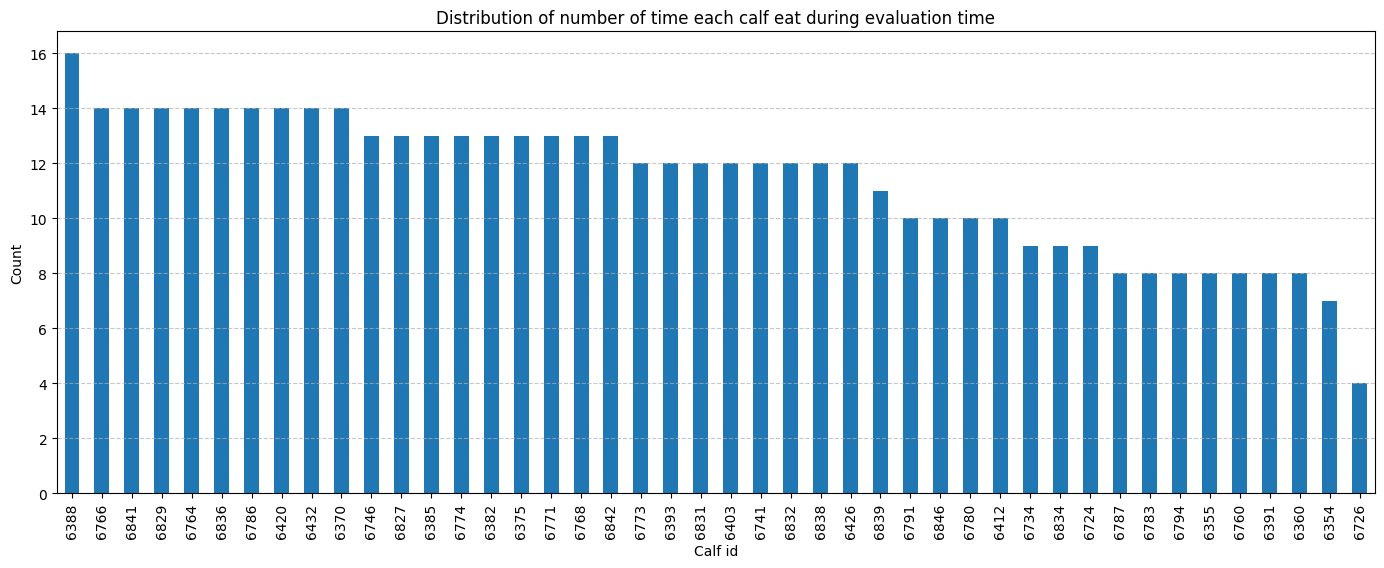

In [20]:
# Count the occurrences of each class
counts = aptm_sampled['calfNumber'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('Calf id')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

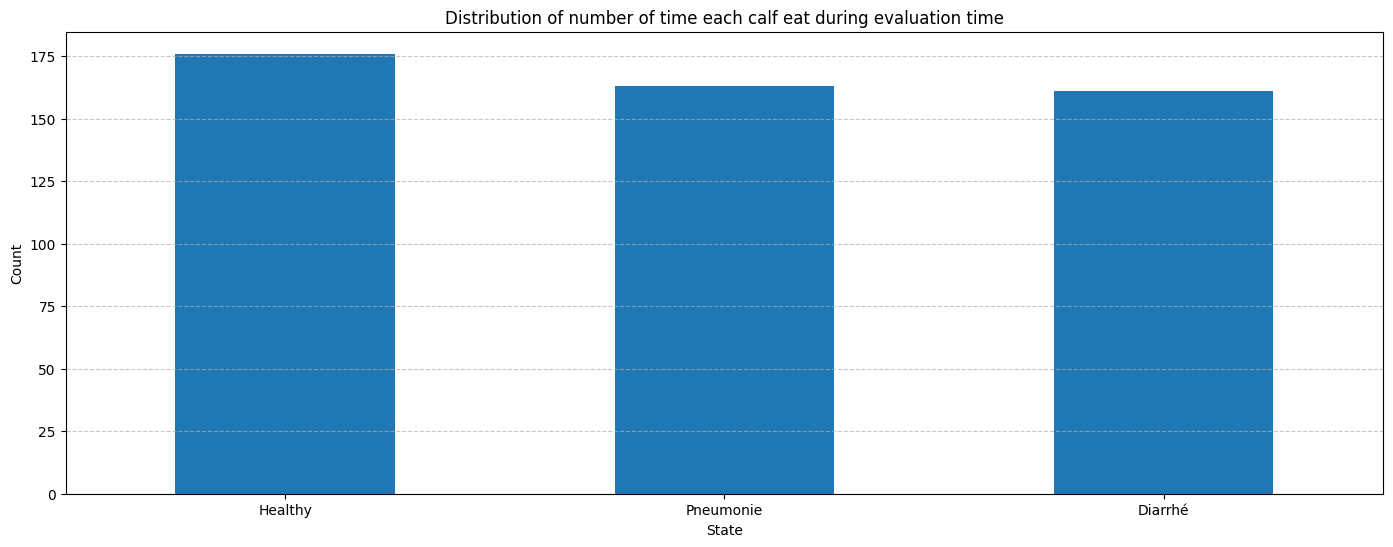

In [21]:
# Count the occurrences of each class
counts = aptm_sampled['State'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
aptm_sampled.shape, aptm_rest.shape, 

((500, 7), (5191, 7))

In [13]:
drop_idx=[]
visited_day = {}
for idx in aptm_with_state.sort_values(by="datetime").index.values:
    if not aptm_with_state.iloc[idx]["day"] in visited_day.keys():
        visited_day[aptm_with_state.iloc[idx]["day"]] = aptm_with_state.iloc[idx]["datetime"]
        continue
    
    diff = (aptm_with_state.iloc[idx]["datetime"] - visited_day[aptm_with_state.iloc[idx]["day"]]).total_seconds()

    if diff < (5 * 60):
        drop_idx.append(idx)
        # print(idx, diff, visited_day[aptm_with_state.iloc[idx]["day"]], aptm_with_state.iloc[idx]["datetime"])
        # break
    else:
        visited_day[aptm_with_state.iloc[idx]["day"]] = aptm_with_state.iloc[idx]["datetime"]
        
    # print(idx, diff, visited_day[aptm_with_state.iloc[idx]["day"]], aptm_with_state.iloc[idx]["datetime"])
    # break

print(len(drop_idx))

9639


In [24]:
aptm_with_state[aptm_with_state.index.isin(drop_idx)].sort_values(by="datetime")

calfNumber parc         day  Duration              cwd  \
993          6726   10  2022-02-16        15  6726 2022-02-16   
1175         6391    2  2022-02-16        52  6391 2022-02-16   
1031         6771    2  2022-02-16       471  6771 2022-02-16   
992          6726   10  2022-02-16        10  6726 2022-02-16   
991          6726   10  2022-02-16         5  6726 2022-02-16   
...           ...  ...         ...       ...              ...   
13293        6435   10  2022-04-15       174  6435 2022-04-15   
12968        6420    9  2022-04-15         7  6420 2022-04-15   
12967        6420    9  2022-04-15       387  6420 2022-04-15   
13129        6834    9  2022-04-15        63  6834 2022-04-15   
13128        6834    9  2022-04-15       351  6834 2022-04-15   

                 datetime    State  
993   2022-02-16 06:11:59  Healthy  
1175  2022-02-16 06:12:02  Diarrhé  
1031  2022-02-16 06:12:54  Diarrhé  
992   2022-02-16 06:13:28  Healthy  
991   2022-02-16 06:13:47  Healthy  
...                   ...      ...  
13293 2022-04-15 21:47:09  Healthy  
12968 2022-04-15 21:49:36  Healthy  
12967 2022-04-15 21:50:46  Healthy  
13129 2022-04-15 21:59:04  Healthy  
13128 2022-04-15 22:00:09  Healthy  

[9639 rows x 7 columns]

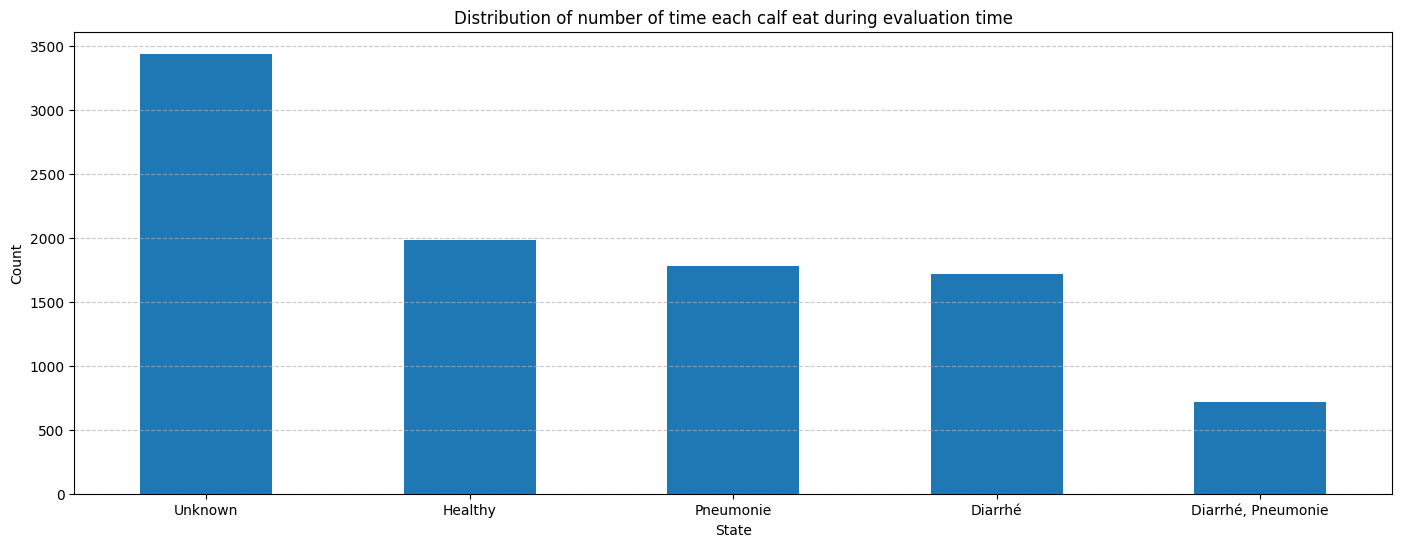

In [33]:
# Count the occurrences of each class
counts = aptm_with_state[aptm_with_state.index.isin(drop_idx)]['State'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

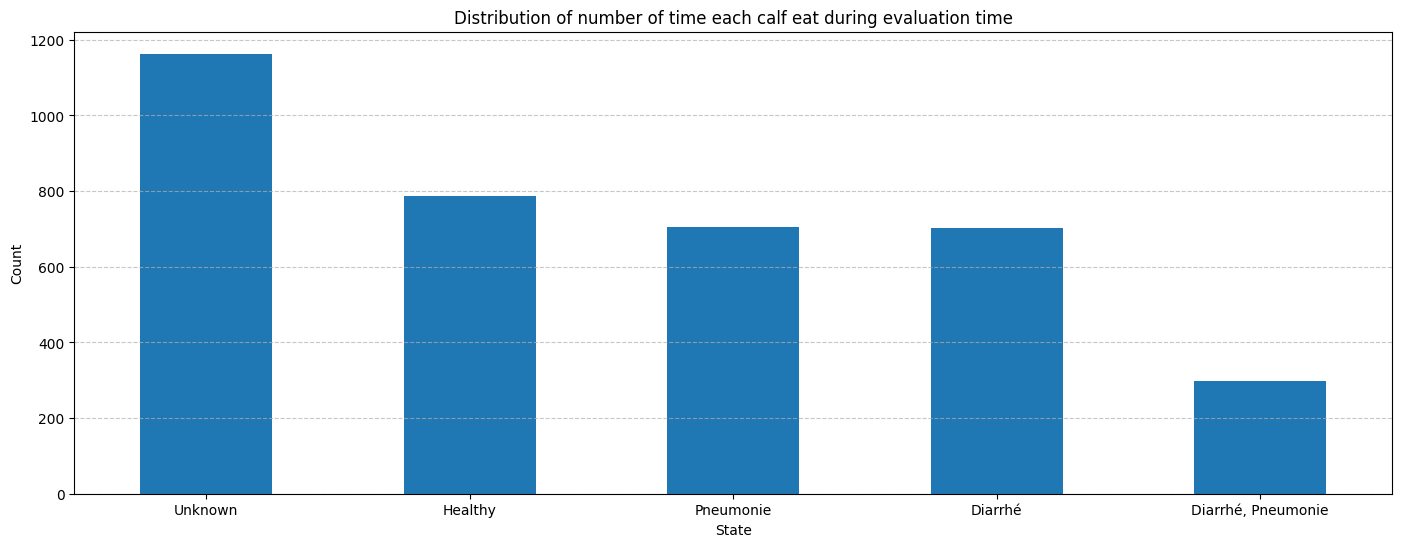

In [34]:
# Count the occurrences of each class
counts = aptm_with_state[~aptm_with_state.index.isin(drop_idx)]['State'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of number of time each calf eat during evaluation time')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
spaced_aptm_with_state = aptm_with_state[~aptm_with_state.index.isin(drop_idx)]
spaced_aptm_with_state.reset_index(drop=True, inplace=True)
spaced_aptm_with_state.shape, (spaced_aptm_with_state.shape[0] / aptm_with_state.shape[0]) * 100

((3657, 7), 27.504512635379065)

In [16]:
# Specify the columns to group by and the sample size
groupby_cols = ['calfNumber', 'parc', 'State']
sample_size = 500

selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() > 150].keys()
filter_values = {
    'calfNumber': selected_calf,  # Specify the values you want to include
    'State': ['Diarrhé', 'Pneumonie', 'Healthy']
}

# Get the uniformly sampled dataframe
# sampled_df = uniform_sample(aptm_with_state, sample_size, groupby_cols)
aptm_sampled, aptm_rest = uniform_sample_with_values(spaced_aptm_with_state, sample_size, groupby_cols, filter_values = filter_values)

In [27]:
aptm_sampled.shape

(500, 7)

### Conclusion 

- Pour reduire le temps requis a l'extraction des donnees, tout en ayant des donnees uniformement distribues, nous avons fait un echantillonnage du jeu de donnees, et pris seulement une certaine quantite pour le jeu d'entrainement
- Le jeu de validation sera creer a partir du reste des donnees

## Setups

In [25]:
ROOT_DIR = "/data/konrad/workspace"
yolo_face = YOLO(ROOT_DIR + "/models/best-face4.pt")
yolo_world = YOLO("yolov8s-world.pt")  
yolo_world.set_classes(["calf face"])

# yolo, _ = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True, trust_repo=True, force_reload=True)
# yolo = mdter.cuda()
# yolo.eval()

# model_name = 'ashkamath/mdetr-resnet50'
# mdter_postprocessor = DetrImageProcessor.from_pretrained(model_name)
# mdter = DetrForObjectDetection.from_pretrained(model_name)

In [7]:
# Read the CSV file into a DataFrame
states = pd.read_csv(ROOT_DIR +'/csv_files/illness.csv')
aptm = pd.read_csv(ROOT_DIR + '/csv_files/visits_point.csv', delimiter=';')

DATA_DIR = "/data/public/heureux_2022-02-16_2022-04-16"
dir_path = DATA_DIR
directories = [d for d in os.listdir(dir_path) if d.startswith("2022") and os.path.isdir(os.path.join(dir_path, d))]

day_to_dir = {}
for d in directories:
    if d.startswith("2022-"):
        p = d.split("-")
        start_date = "-".join(p[:3])
        end_date = "-".join(p[3:])
        date_range = pd.date_range(start=start_date, end=end_date)
        day_to_dir.update({md:d for md in date_range.strftime('%Y-%m-%d').tolist()})

day_to_dir['2022-02-02'] = "2022_02_02"

mp4_files = []
for d in directories:
    try:
        path = dir_path + "/" + d
        # print(path)
        for f in os.listdir(path):
            if f.endswith(".mp4") and os.path.isfile(os.path.join(path, f)):
                filename = f[:-4].split("_")
                start_date = filename[3][:4] + "-" + filename[3][4:6] + "-" + filename[3][6:8] + "T" + filename[3][8:10] + ":" + filename[3][10:12] + ":" + filename[3][12:]
                end_date = filename[4][:4] + "-" + filename[4][4:6] + "-" + filename[4][6:8] + "T" + filename[4][8:10] + ":" + filename[4][10:12] + ":" + filename[4][12:]
                station = filename[1][2:]
                # print(filename, start_date, end_date, station)
                # print(os.path.join(path, f))
                mp4_files.append({"station": station, "start_at": start_date, "end_at": end_date, "path": os.path.join(path, f)})
                # break
            
    except Exception as e:
        continue

mp4_files = pd.DataFrame(mp4_files)
mp4_files["start_time"] = pd.to_datetime(mp4_files["start_at"])
mp4_files["end_time"] = pd.to_datetime(mp4_files["end_at"])
mp4_files["start_date"] = mp4_files["start_time"].dt.date
mp4_files["start_hour"] = mp4_files["start_time"].dt.hour
mp4_files["start_mn"] = mp4_files["start_time"].dt.minute
mp4_files = mp4_files[mp4_files["station"].isin(["1","2","9","10"])]

In [8]:
states['State'] = states.apply(determine_state, axis=1)
states = states[~states["State"].isna()]

columns = ["calfNumber", "station", "Duration", "localDate", "date", "feederLong"]
aptm["datetime"] = pd.to_datetime(aptm["localDate"])
aptm["day"] = aptm["datetime"].dt.date
aptm["hour"] = aptm["datetime"].dt.time

# Only data for eval date
stated_aptm = aptm[aptm["day"].apply(str).isin(states.date.unique())][columns + ["day", "hour", "datetime"]]
stated_aptm["parc"] = None
stated_aptm.loc[(stated_aptm["station"]==1) & (stated_aptm["feederLong"]=="DAL 2 (2496)"), 'parc']="9" #louve 3
stated_aptm.loc[(stated_aptm["station"]==2) & (stated_aptm["feederLong"]=="DAL 2 (2496)"), 'parc']="10" #louve 4
stated_aptm.loc[(stated_aptm["station"]==2) & (stated_aptm["feederLong"]=="DAL 1 (2494)"), 'parc']="1"  #louve 2 
stated_aptm.loc[(stated_aptm["station"]==1) & (stated_aptm["feederLong"]=="DAL 1 (2494)"), 'parc']="2" #louve 1
stated_aptm = stated_aptm[stated_aptm["Duration"] > 0]
stated_aptm = stated_aptm[~stated_aptm["parc"].isna()]
# Only data for available recorded video dates
stated_aptm = stated_aptm[stated_aptm["day"].apply(str).isin(day_to_dir.keys())]
# Only apptm for available recorded video hour
stated_aptm = stated_aptm[(stated_aptm["datetime"].dt.hour >= 6) & (stated_aptm["datetime"].dt.hour <= 22)]
stated_aptm["cwd"] = stated_aptm["calfNumber"].astype(str) + " " + stated_aptm["day"].astype(str)
states["cwd"] = states["No ATQ"].astype(str) + " " + states["date"].astype(str)
aptm_with_state = pd.merge(stated_aptm[["calfNumber", "parc", "day", "Duration", "cwd", "datetime"]], states[["State", "cwd"]], on="cwd", how='inner')

drop_idx=[]
visited_day = {}
minutes = 3
for idx in aptm_with_state.sort_values(by="datetime").index.values:
    key = "{day}_{parc}".format(day=aptm_with_state.iloc[idx]["day"], parc=aptm_with_state.iloc[idx]["parc"])

    if not key in visited_day.keys():
        visited_day[key] = aptm_with_state.iloc[idx]["datetime"] +  pd.Timedelta(seconds=aptm_with_state.iloc[idx]["Duration"])
        continue
    
    diff = (aptm_with_state.iloc[idx]["datetime"] - visited_day[key]).total_seconds()
    
    if diff < (minutes * 60):
        drop_idx.append(idx)
    else:
        visited_day[key] = aptm_with_state.iloc[idx]["datetime"]

spaced_aptm_with_state = aptm_with_state[~aptm_with_state.index.isin(drop_idx)]
spaced_aptm_with_state.reset_index(drop=True, inplace=True)

# aptm_with_state.to_csv('aptm_with_state.csv', index=False)
# spaced_aptm_with_state.to_csv('spaced_aptm_with_state.csv', index=False)
# mp4_files.to_csv('mp4_files.csv', index=False)

In [9]:
# # Specify the columns to group by and the sample size
# groupby_cols = ['calfNumber', 'parc', 'State']
# sample_size = 2000
# eating_threshold = 100

# selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() >= eating_threshold].keys()
# filter_values = {
#     'calfNumber': selected_calf,  # Specify the values you want to include
#     'State': ['Diarrhé', 'Pneumonie', 'Healthy']
# }

# # Get the uniformly sampled dataframe
# # sampled_df = uniform_sample(aptm_with_state, sample_size, groupby_cols)
# aptm_sampled, aptm_rest = uniform_sample_with_values(spaced_aptm_with_state, sample_size, groupby_cols, filter_values = filter_values)
# aptm_sampled = aptm_sampled.sample(frac=1).reset_index(drop=True)

# selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() < eating_threshold].keys()
# filter_values["calfNumber"] = selected_calf
# sample_size = 40 * 3

# # Get the uniformly sampled dataframe
# # sampled_df = uniform_sample(aptm_with_state, sample_size, groupby_cols)
# test_aptm_sampled, aptm_rest = uniform_sample_with_values(spaced_aptm_with_state, sample_size, groupby_cols, filter_values = filter_values)
# test_aptm_sampled = test_aptm_sampled.sample(frac=1).reset_index(drop=True)

# # Get only a selected calf per set
# selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() >= eating_threshold].keys()
# aptm_sampled = spaced_aptm_with_state[spaced_aptm_with_state["calfNumber"].isin(selected_calf)]
# selected_calf = aptm_with_state["calfNumber"].value_counts()[aptm_with_state["calfNumber"].value_counts() < eating_threshold].keys()
# test_aptm_sampled = spaced_aptm_with_state[spaced_aptm_with_state["calfNumber"].isin(selected_calf)]

aptm_sampled = spaced_aptm_with_state[spaced_aptm_with_state["State"].isin(['Diarrhé', 'Pneumonie', 'Healthy', 'Diarrhé, Pneumonie'])]

In [10]:
mp4_files.shape, aptm_with_state.shape, spaced_aptm_with_state.shape, aptm_sampled.shape

((3844, 9), (13296, 7), (6362, 7), (3854, 7))

In [ ]:
spaced_time = []
visited_day = {}
for i, idx in enumerate(aptm_with_state.sort_values(by="datetime").index.values):
    
    key = "{day}_{parc}".format(day=aptm_with_state.iloc[idx]["day"], parc=aptm_with_state.iloc[idx]["parc"])
    
    if not key in visited_day.keys():
        visited_day[key] = aptm_with_state.iloc[idx]["datetime"] +  pd.Timedelta(seconds=aptm_with_state.iloc[idx]["Duration"])
        continue
        
    last_end = visited_day[key]
    diff = (aptm_with_state.iloc[idx]["datetime"] - last_end).total_seconds()
    if diff < 0:
        print(key, last_end, aptm_with_state.iloc[idx]["datetime"])
        
    visited_day[key] = aptm_with_state.iloc[idx]["datetime"] +  pd.Timedelta(seconds=aptm_with_state.iloc[idx]["Duration"])
    spaced_time.append(diff)

In [51]:
(pd.Series(spaced_time) // 60).describe()

count    13189.000000
mean         4.776329
std         17.399375
min        -40.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        573.000000
dtype: float64

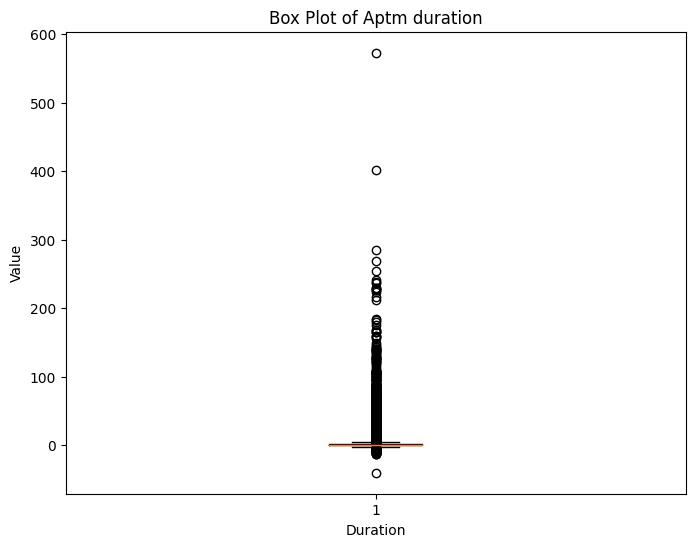

In [53]:
plt.figure(figsize=(8, 6))
plt.boxplot((pd.Series(spaced_time) // 60))
plt.xlabel('Duration')
plt.ylabel('Value')
plt.title('Box Plot of Aptm duration')
plt.show()

## Extraction

In [6]:
nv = aptm_sampled.shape[0]

print(f"Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) {format_time(5 * nv)}")
print(f"Nombre d'heure extrait au total {format_time(20 * nv)}")

Nombre de temps pour l'extraction des visites de 20s (pour 5s/video) 00:41:40
Nombre d'heure extrait au total 02:46:40


In [28]:
# Start time
start_time = time.time()

frame = 10
step = 0
frame_sample_rate = 4
num_images = 20
ibbox_conf = .80
vbbox_conf = .50
delta = frame + step

# root_dir = f"/data/data_calves/konrad/mixed_{frame}s_b{step}s"
root_dir = ROOT_DIR + f"/datasets/mixed_{frame}s_b{step}s"
# root_dir = ROOT_DIR + "/datasets/videos/train"

# records = extract_medias(aptm_sampled, mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, video_model = yolo_world, image_model = yolo_face, bbox_conf = (ibbox_conf, vbbox_conf))
records = extract_medias(aptm_sampled.iloc[:100], mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, video_model = yolo_world, image_model = yolo_face, bbox_conf = (ibbox_conf, vbbox_conf))
# records = extract_videos_mdetr(aptm_sampled.iloc[:100], mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
# records = extract_videos(aptm_sampled.iloc[:100], mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
# records = extract_videos(aptm_sampled, mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
# records = extract_videos(aptm_sampled.iloc[:10], mp4_files, root_dir, delta = delta, step = step)
# records = extract_videos(aptm_sampled, mp4_files, root_dir, delta = delta, step = step)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

formatted_time = format_time(elapsed_time)
records[0].to_csv(root_dir + '/videos_metadata.csv', index=False)
records[1].to_csv(root_dir + '/images_metadata.csv', index=False)
records[2].to_csv(root_dir + '/indices_metadata.csv', index=False)
# records.to_csv('train_video_extracted_metadata.csv', index=False)

# Display the elapsed time
print(f"Time of execution: {formatted_time} from {elapsed_time}")

Time of execution: 00:11:17 from 677.908976316452


In [12]:
# total videos with more than 1 detected with y_world, and number of images extracted by y_face
records[0].shape, records[1].shape

((45, 9), (44, 12))

In [18]:
# total videos extracted, then total videos with a least one detection by y_face, and number of images extracted by y_face 3
records[0].shape, records[0][records[0]['nfaces'] > 0].shape, records[1].shape

((96, 9), (29, 9), (118, 12))

In [29]:
# total videos extracted, then total videos with a least one detection by y_face, and number of images extracted by y_face 4
records[0].shape, records[0][records[0]['nfaces'] > 0].shape, records[1].shape

((96, 9), (28, 9), (70, 12))

In [24]:
# total videos with more than 1 detected with y_world, then total videos with a least one detection by y_face, and number of images extracted by y_face
records[0].shape, records[0][records[0]['ncalfs'] > 0].shape,  records[0][records[0]['nfaces'] > 0].shape, records[1].shape

((51, 10), (51, 10), (19, 10), (54, 12))

In [53]:
aptm_sampled[330:332]

calfNumber parc         day  Duration              cwd  \
330        6836    9  2022-03-10       303  6836 2022-03-10   
331        6355    9  2022-02-16       234  6355 2022-02-16   

               datetime      State  
330 2022-03-10 11:41:26    Healthy  
331 2022-02-16 18:41:17  Pneumonie

In [60]:
one_row = aptm_sampled.iloc[330]
target = one_row['State']

cond = (
    (mp4_files["start_date"] == one_row.datetime.date())
    & (mp4_files["start_time"] <= one_row.datetime)
    & (mp4_files["end_time"] > one_row.datetime)
    # & (mp4_files["start_hour"] == one_row.datetime.hour)
    # & (mp4_files["start_mn"] <= one_row.datetime.minute)
    & (mp4_files["station"] == one_row.parc)
)
mp4_files[cond]

station             start_at               end_at  \
6555       9  2022-03-10T11:41:17  2022-03-10T12:44:45   

                                                   path          start_time  \
6555  /data/public/heureux_2022-02-16_2022-04-16/202... 2022-03-10 11:41:17   

      start_date  start_hour  start_mn            end_time  
6555  2022-03-10          11        41 2022-03-10 12:44:45

In [ ]:
# Start time
start_time = time.time()

frame = 10
step = 2
frame_sample_rate = 4
num_images = 20
bbox_conf = .85
delta = frame + step
# root_dir = ROOT_DIR + "/datasets/videos/sample"
# root_dir = ROOT_DIR + "/datasets/videos/train"
root_dir = f"/data/data_calves/konrad/videos_{frame}_{step}/"
directory = root_dir + "train"

# records = extract_videos(aptm_sampled.iloc[:10], mp4_files, root_dir, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
records = extract_videos(aptm_sampled, mp4_files, directory, delta = delta, step = step, frame_sample_rate = frame_sample_rate, num_images = num_images, model = yolo, bbox_conf = bbox_conf)
# records = extract_videos(aptm_sampled.iloc[:10], mp4_files, root_dir, delta = delta, step = step)
# records = extract_videos(aptm_sampled, mp4_files, root_dir, delta = delta, step = step)

# End time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

formatted_time = format_time(elapsed_time)
records.to_csv(root_dir + 'train_video_extracted_metadata.csv', index=False)

# Display the elapsed time
print(f"Time of execution: {formatted_time} from {elapsed_time}")

In [14]:
records.shape

(275, 9)

## EDA of extracted data

In [17]:
csv_path = "train_video_extracted_metadata.csv"
train_df = pd.read_csv(csv_path, index_col=False)
csv_path = "val_video_extracted_metadata.csv"
valid_df = pd.read_csv(csv_path, index_col=False)

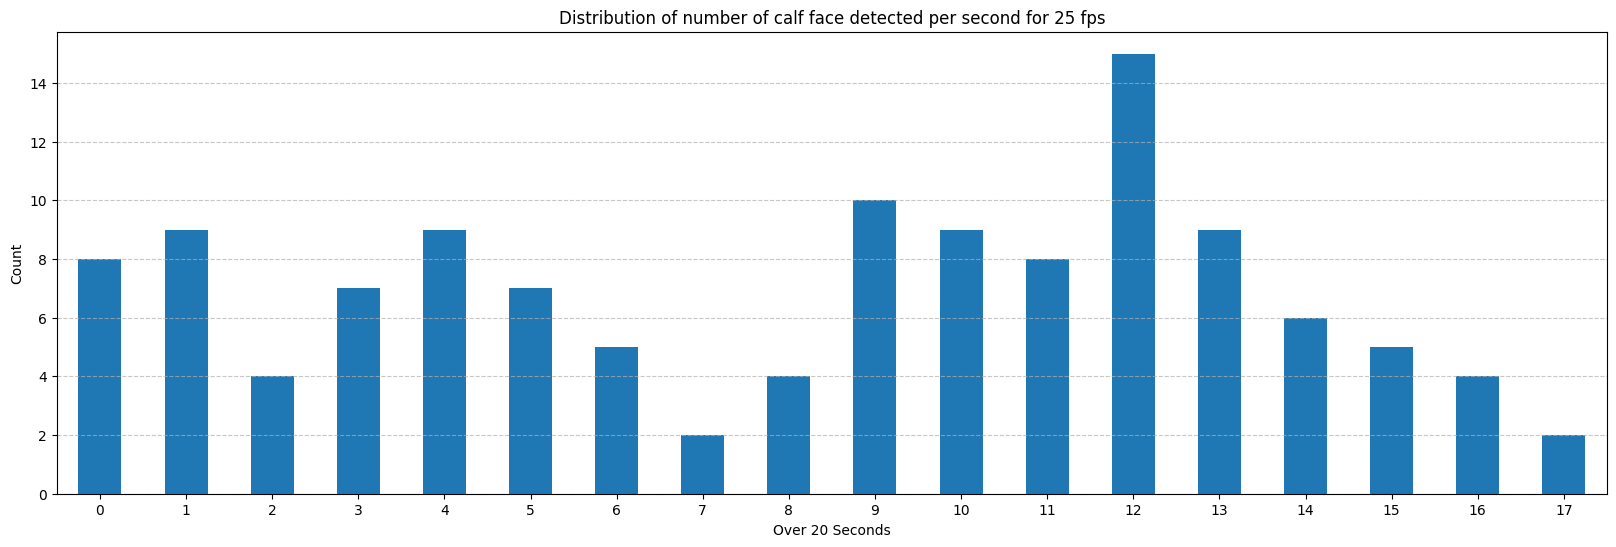

In [16]:
# Time of execution: 00:55:34 from 3334.65287065506
indices = records[2]
for fp in indices["fps"].value_counts().keys():
    tempo = (indices[indices["fps"] == fp]['idx'] // fp).astype(int)
    counts = tempo.value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(20, 6))
    counts.plot(kind='bar')
    plt.title(f'Distribution of number of calf face detected per second for {fp} fps')
    plt.xlabel(f'Over {frame} Seconds')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

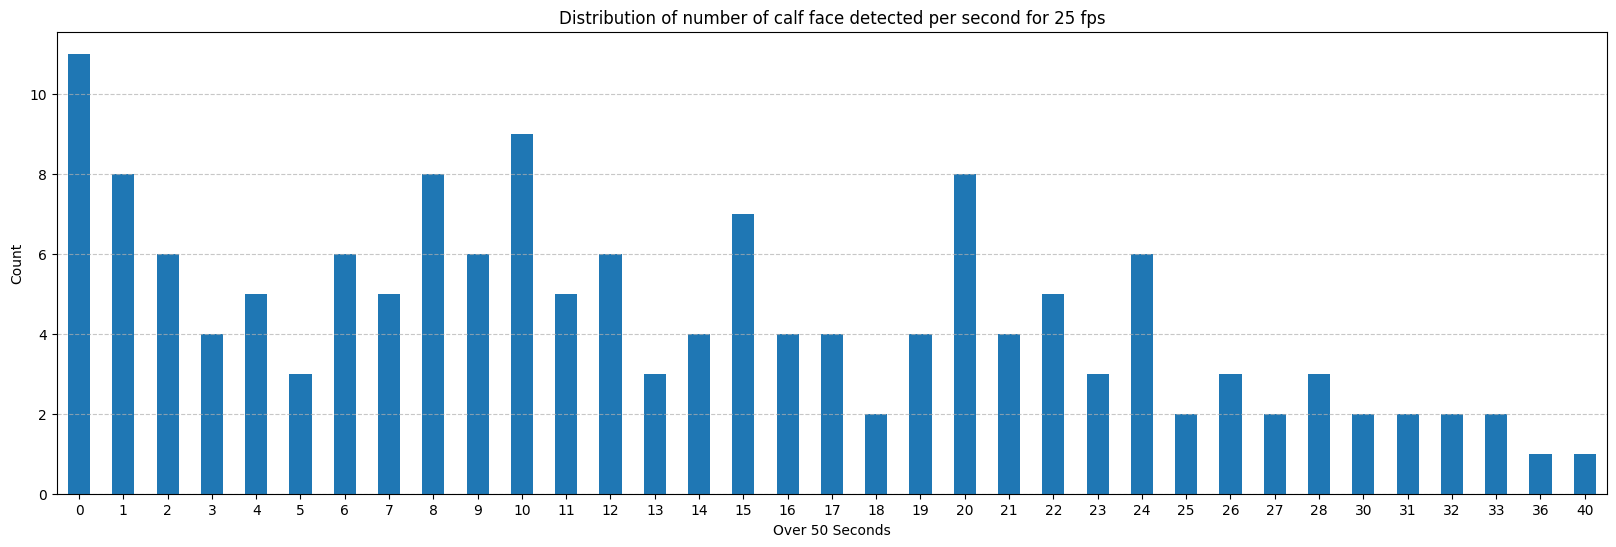

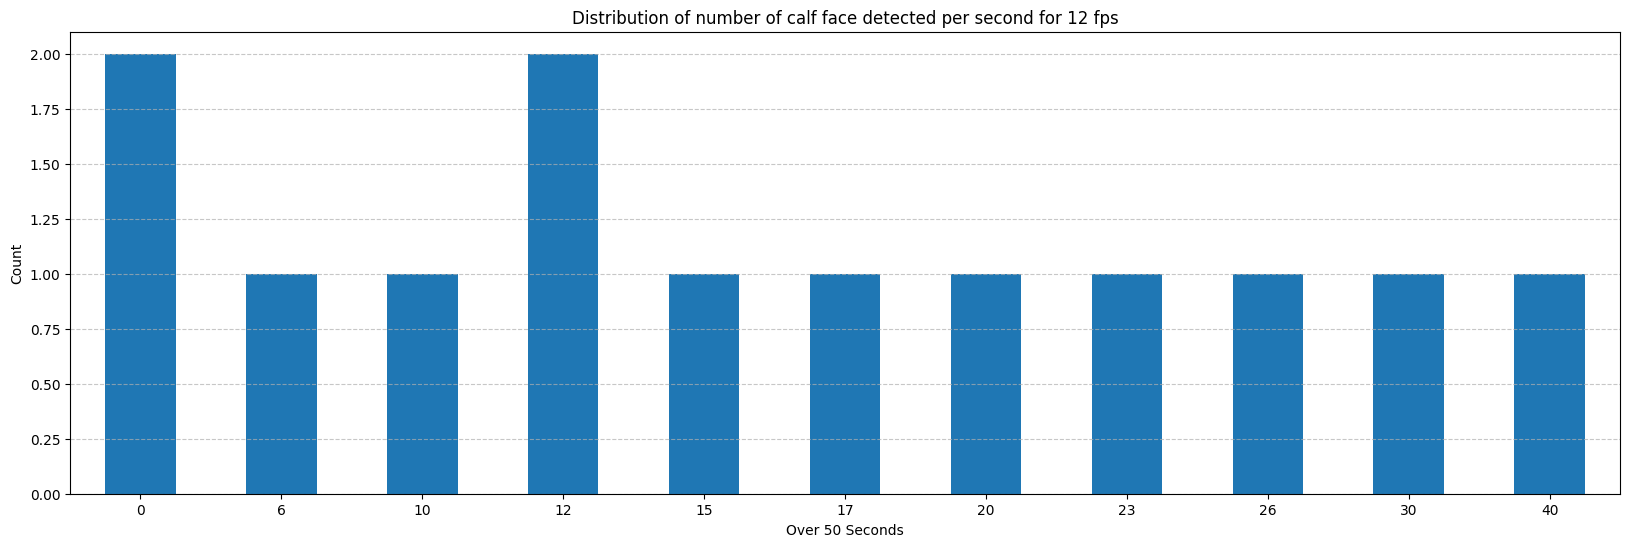

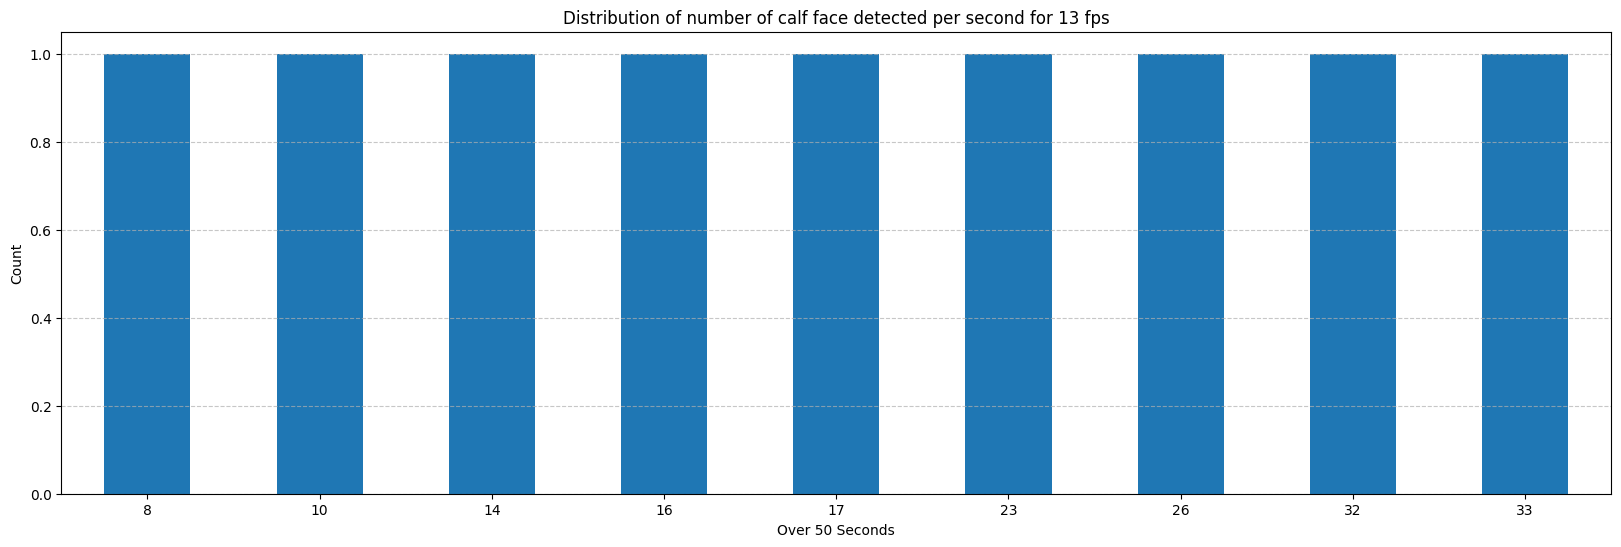

In [78]:
# Time of execution: 00:55:34 from 3334.65287065506
indices = records[2]
for fp in indices["fps"].value_counts().keys():
    tempo = (indices[indices["fps"] == fp]['idx'] // fp).astype(int)
    counts = tempo.value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(20, 6))
    counts.plot(kind='bar')
    plt.title(f'Distribution of number of calf face detected per second for {fp} fps')
    plt.xlabel(f'Over {frame} Seconds')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

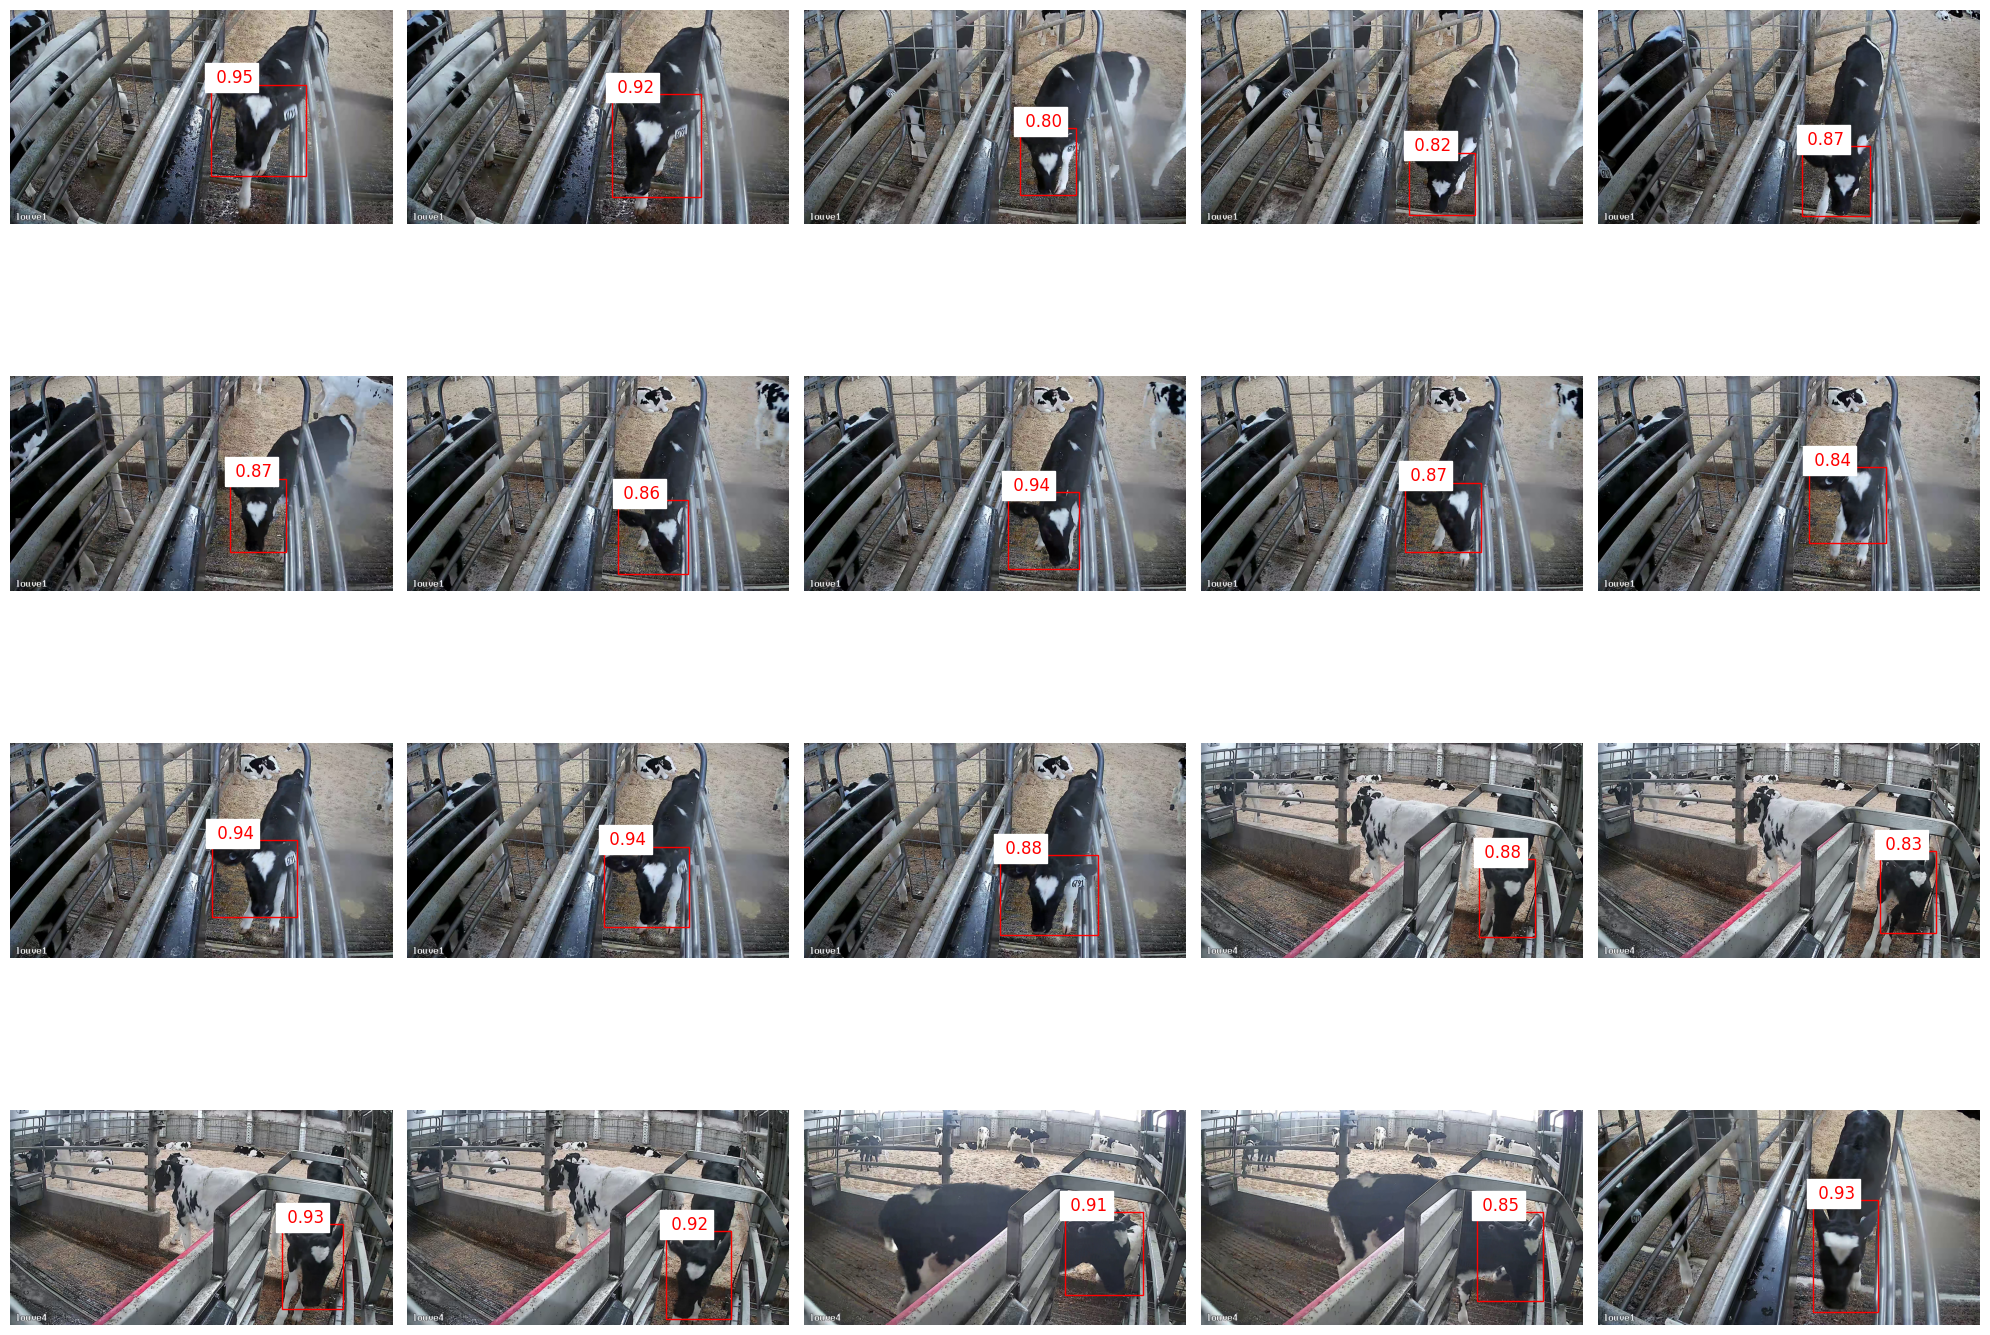

In [14]:
image_paths = records[1][:20].reset_index(drop=True)
# image_paths.shape
plot_bbox_gallery(image_paths)

In [ ]:
images = records[1][~records[1]["passed"]]["path"].tolist()
results = yolo_face.predict(images, save=False, conf=0.80, max_det=1, show=False, visualize=False)
clear_output()
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    plt.figure(figsize=(10, 10))
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
    plt.imshow(im_rgb)

In [ ]:
images = records[1][~records[1]["passed"]]["path"].tolist()
images = [Image.open(im) for im in images]
results = yolo_face.predict(images, save=False, conf=0.85, max_det=1, show=False, visualize=False)
clear_output()
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    plt.figure(figsize=(10, 10))
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
    plt.imshow(im_rgb)

In [ ]:
image_paths = records[1][records[1]["passed"]]["path"].tolist()
plot_gallery(image_paths)

In [30]:
train_df["label"].unique()

array(['Diarrhé', 'Unknown', 'Diarrhé, Pneumonie', 'Healthy', 'Pneumonie'], dtype=object)

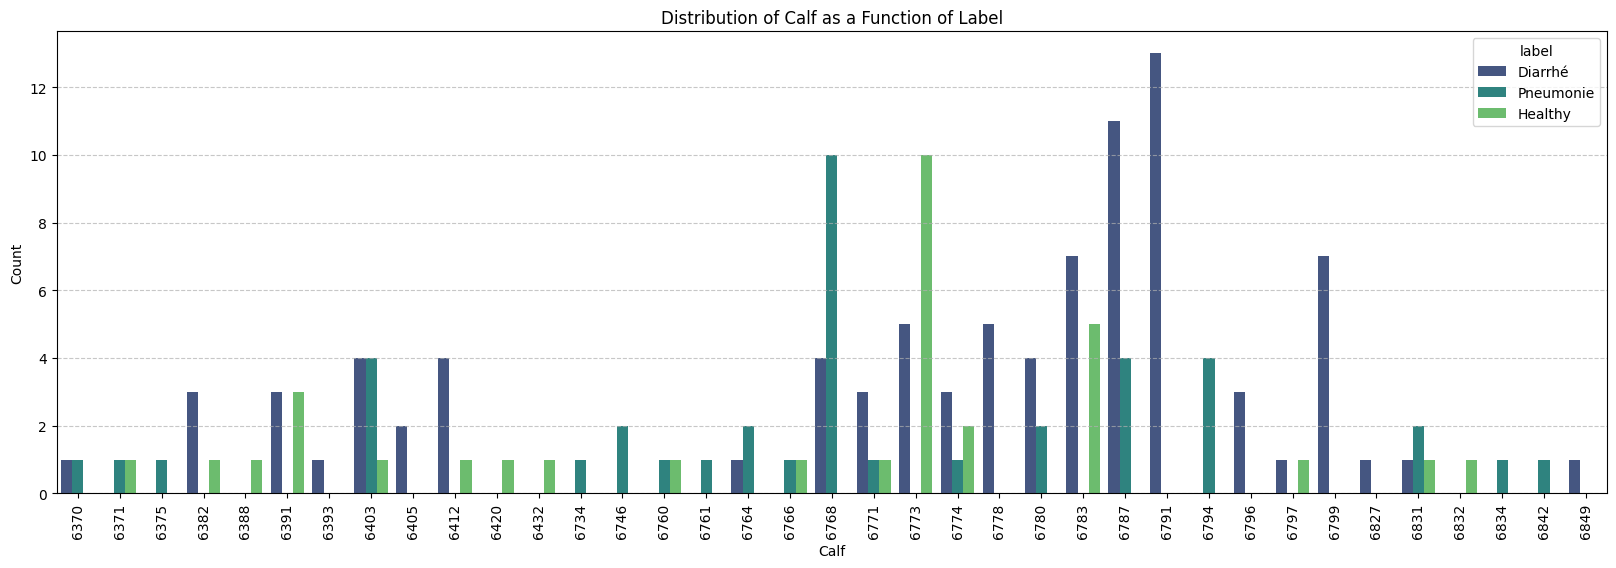

In [32]:
# Group by label and calf, and count the occurrences
sub_train_df = train_df[~train_df["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]
calf_distribution = sub_train_df.groupby(['label', 'calf']).size().reset_index(name='count')

# Plotting the distribution as a barplot
plt.figure(figsize=(20, 6))
sns.barplot(x='calf', y='count', hue='label', data=calf_distribution, palette='viridis')
plt.title('Distribution of Calf as a Function of Label')
plt.xlabel('Calf')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

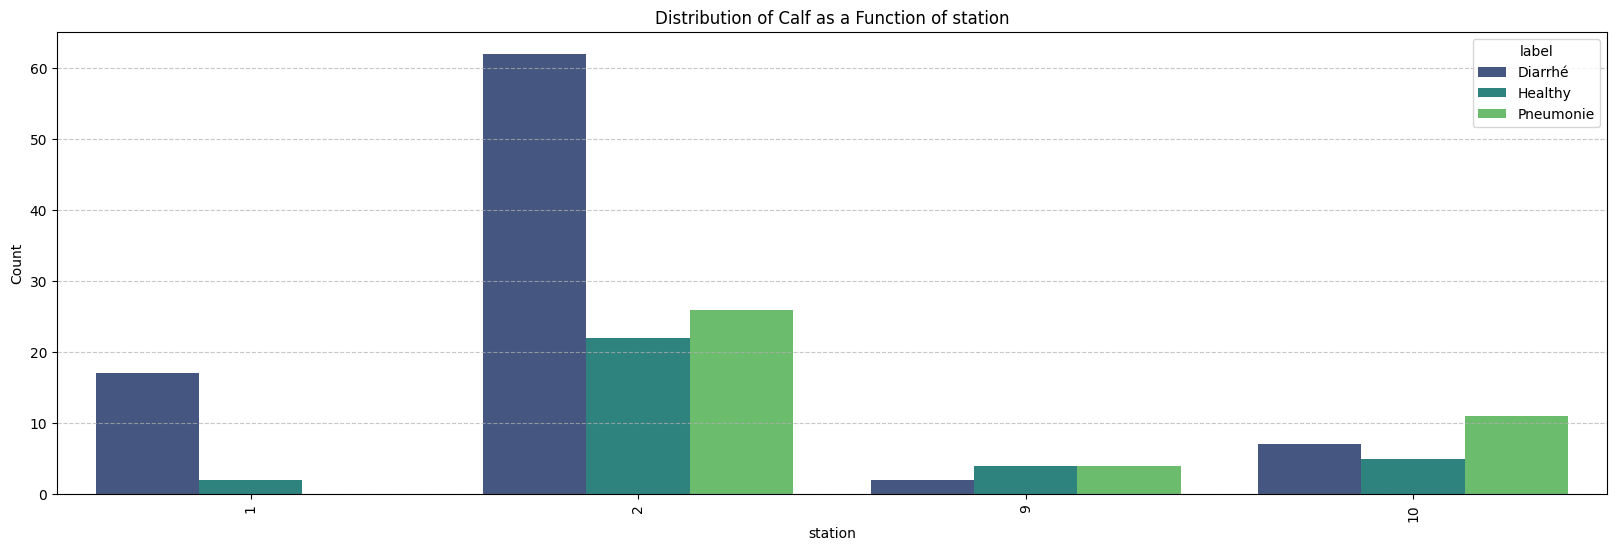

In [34]:
# Group by label and calf, and count the occurrences
sub_train_df = train_df[~train_df["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]
calf_distribution = sub_train_df.groupby(['label', 'station']).size().reset_index(name='count')

# Plotting the distribution as a barplot
plt.figure(figsize=(20, 6))
sns.barplot(x='station', y='count', hue='label', data=calf_distribution, palette='viridis')
plt.title('Distribution of Calf as a Function of station')
plt.xlabel('station')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

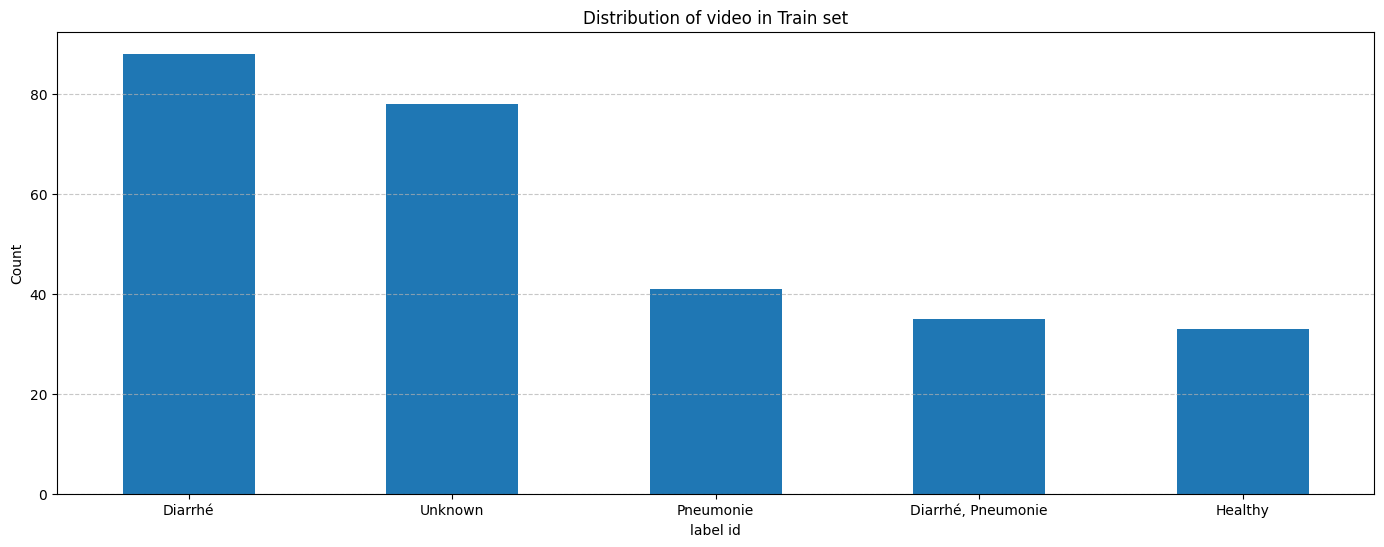

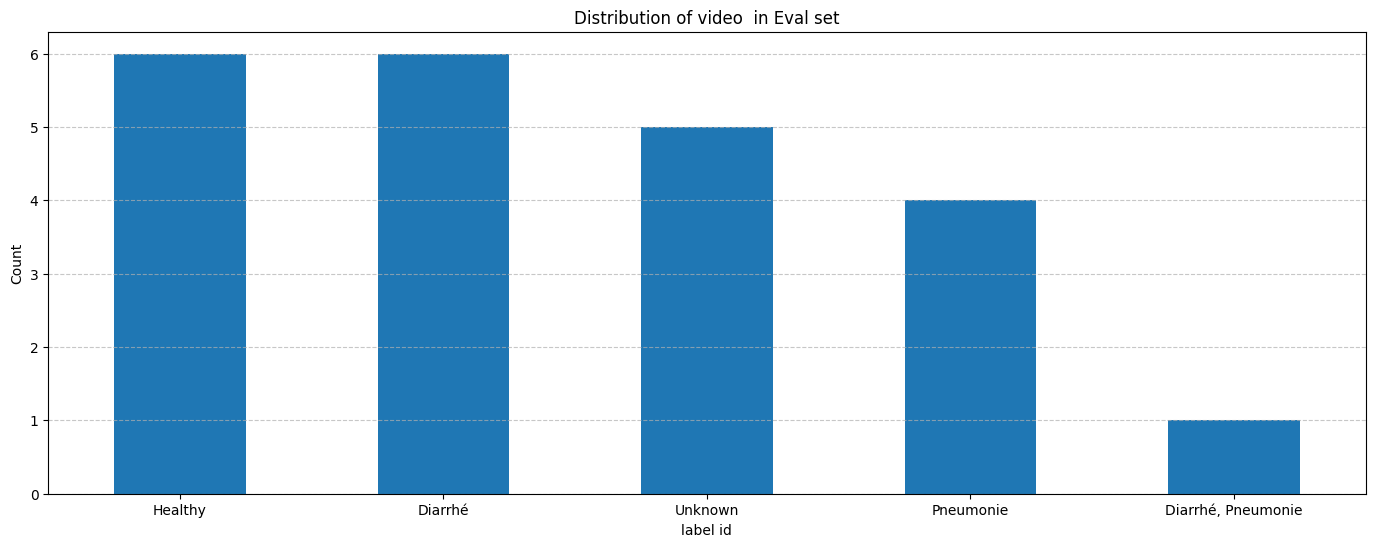

In [40]:
# Count the occurrences of each class
counts = train_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of video in Train set')
plt.xlabel('label id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Count the occurrences of each class
counts = valid_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of video  in Eval set')
plt.xlabel('label id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
train_df['calf'].unique(), train_df['calf'].unique().size

(array([6791, 6768, 6794, 6724, 6780, 6787, 6403, 6391, 6388, 6771, 6778, 6783, 6773, 6761, 6774, 6746, 6393, 6375, 6370, 6797, 6796, 6382, 6412, 6799, 6371, 6764, 6728, 6405, 6786, 6734, 6760, 6766, 6831, 6842, 6827, 6832, 6829, 6834, 6432, 6849, 6426, 6420]),
 42)

In [21]:
valid_df['calf'].unique(), valid_df['calf'].unique().size

(array([6410, 6407, 6404, 6811, 6810, 6800, 6435, 6431, 6445, 6865, 6441, 6422]),
 12)